<a href="https://colab.research.google.com/github/jessalynlc/IDS705_final_project/blob/main/data_scrape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import requests
import json
import pandas as pd
import numpy as np

In [49]:
%reset -f


# 1. Exploratory Data Analysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('../data/02_processed/all_hourly_data_v2.csv', low_memory=False)

# rename column
df.rename(columns={'Hub Average LMP': 'lmp_HB_BUSAVG'}, inplace=True)



## 1.1 Target Variable

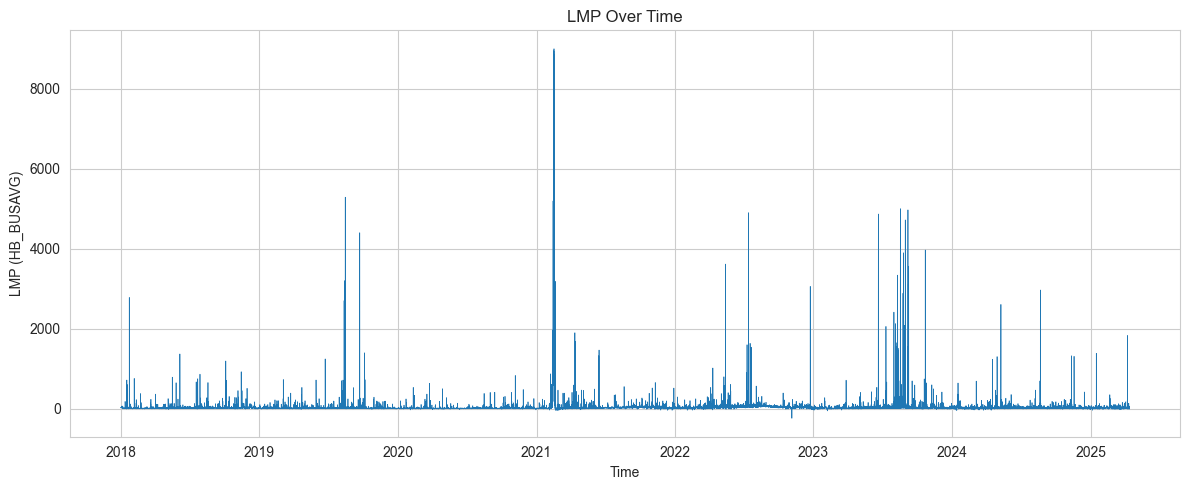

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df['interval_start_local'] = pd.to_datetime(df['interval_start_local'],utc=True)
df = df.sort_values('interval_start_local')


plt.figure(figsize=(12, 5))
plt.plot(df['interval_start_local'], df['lmp_HB_BUSAVG'], linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('LMP (HB_BUSAVG)')
plt.title('LMP Over Time')
plt.grid(True)
plt.tight_layout()

plt.show()


In [39]:
from statsmodels.tsa.stattools import adfuller

#
series = df['lmp_HB_BUSAVG']

#
result = adfuller(series, maxlag=12, regression='c')  #

print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value:        {result[1]:.4f}")
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")


ADF Statistic: -30.0941
p-value:        0.0000
Critical Value (1%): -3.4305
Critical Value (5%): -2.8616
Critical Value (10%): -2.5668


<Figure size 640x480 with 0 Axes>

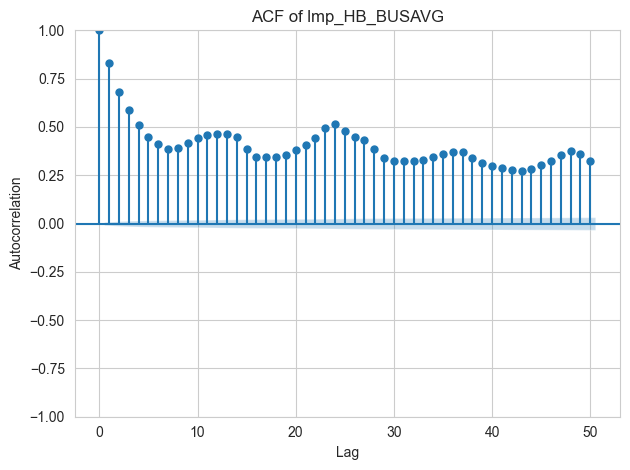

<Figure size 640x480 with 0 Axes>

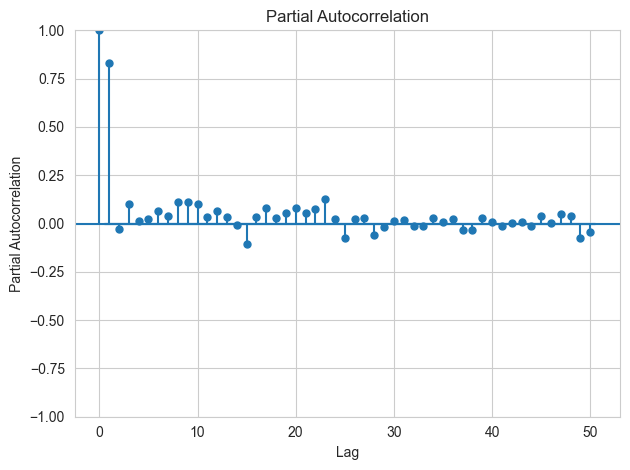

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

#
series = df['lmp_HB_BUSAVG'].dropna()

#
plt.figure()
plot_acf(series, lags=50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of lmp_HB_BUSAVG')
plt.tight_layout()
plt.show()

#
plt.figure()
plot_pacf(series, lags=50)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.show()


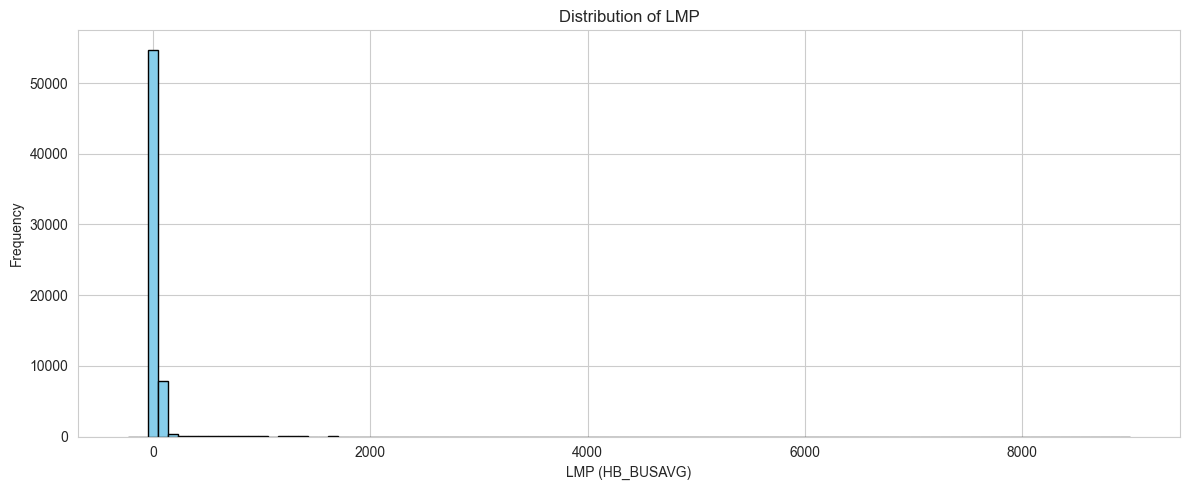

In [15]:
plt.figure(figsize=(12, 5))
plt.hist(df['lmp_HB_BUSAVG'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('LMP (HB_BUSAVG)')
plt.ylabel('Frequency')
plt.title('Distribution of LMP')
plt.grid(True)
plt.tight_layout()
plt.show()


✅ LMP Summary Statistics:
Mean: 40.05
Median: 21.09
Standard Deviation: 206.53
Skewness: 26.95
Kurtosis: 901.89


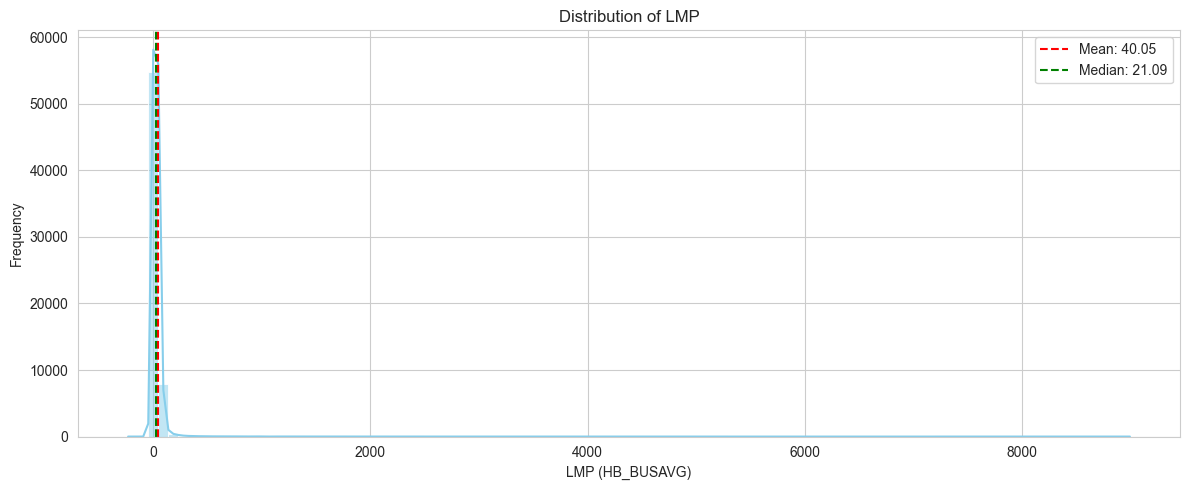

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis


df = pd.read_csv('all_hourly_data.csv')


lmp = df['lmp_HB_BUSAVG']


mean_val = lmp.mean()
median_val = lmp.median()
std_val = lmp.std()
skew_val = skew(lmp)
kurt_val = kurtosis(lmp)  # Fisher's definition (normal dist = 0)


print(f"✅ LMP Summary Statistics:")
print(f"Mean: {mean_val:.2f}")
print(f"Median: {median_val:.2f}")
print(f"Standard Deviation: {std_val:.2f}")
print(f"Skewness: {skew_val:.2f}")
print(f"Kurtosis: {kurt_val:.2f}")


plt.figure(figsize=(12, 5))
sns.histplot(lmp, bins=100, kde=True, color='skyblue')
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
plt.xlabel('LMP (HB_BUSAVG)')
plt.ylabel('Frequency')
plt.title('Distribution of LMP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
#
print(df.isnull().sum())

interval_start_local    0
date                    0
hour                    0
north_x_load            0
south_load              0
west_x_load             0
houston_load            0
total_load              0
lmp_HB_BUSAVG           0
coal_and_lignite        0
hydro                   0
nuclear                 0
power_storage           0
solar                   0
wind                    0
natural_gas             0
other_gen               0
coast_temp              0
east_temp               0
far_west_temp           0
north_y_temp            0
north_central_temp      0
south_central_temp      0
southern_temp           0
west_y_temp             0
day_of_week             0
day_of_month            0
month                   0
lmp_lag_1               0
lmp_lag_2               0
lmp_lag_3               0
lmp_lag_24              0
lmp_lag_48              0
lmp_roll_mean_24        0
lmp_roll_mean_48        0
lmp_roll_mean_96        0
lmp_roll_mean_168       0
dtype: int64


## 1.2 Correlation Matrix

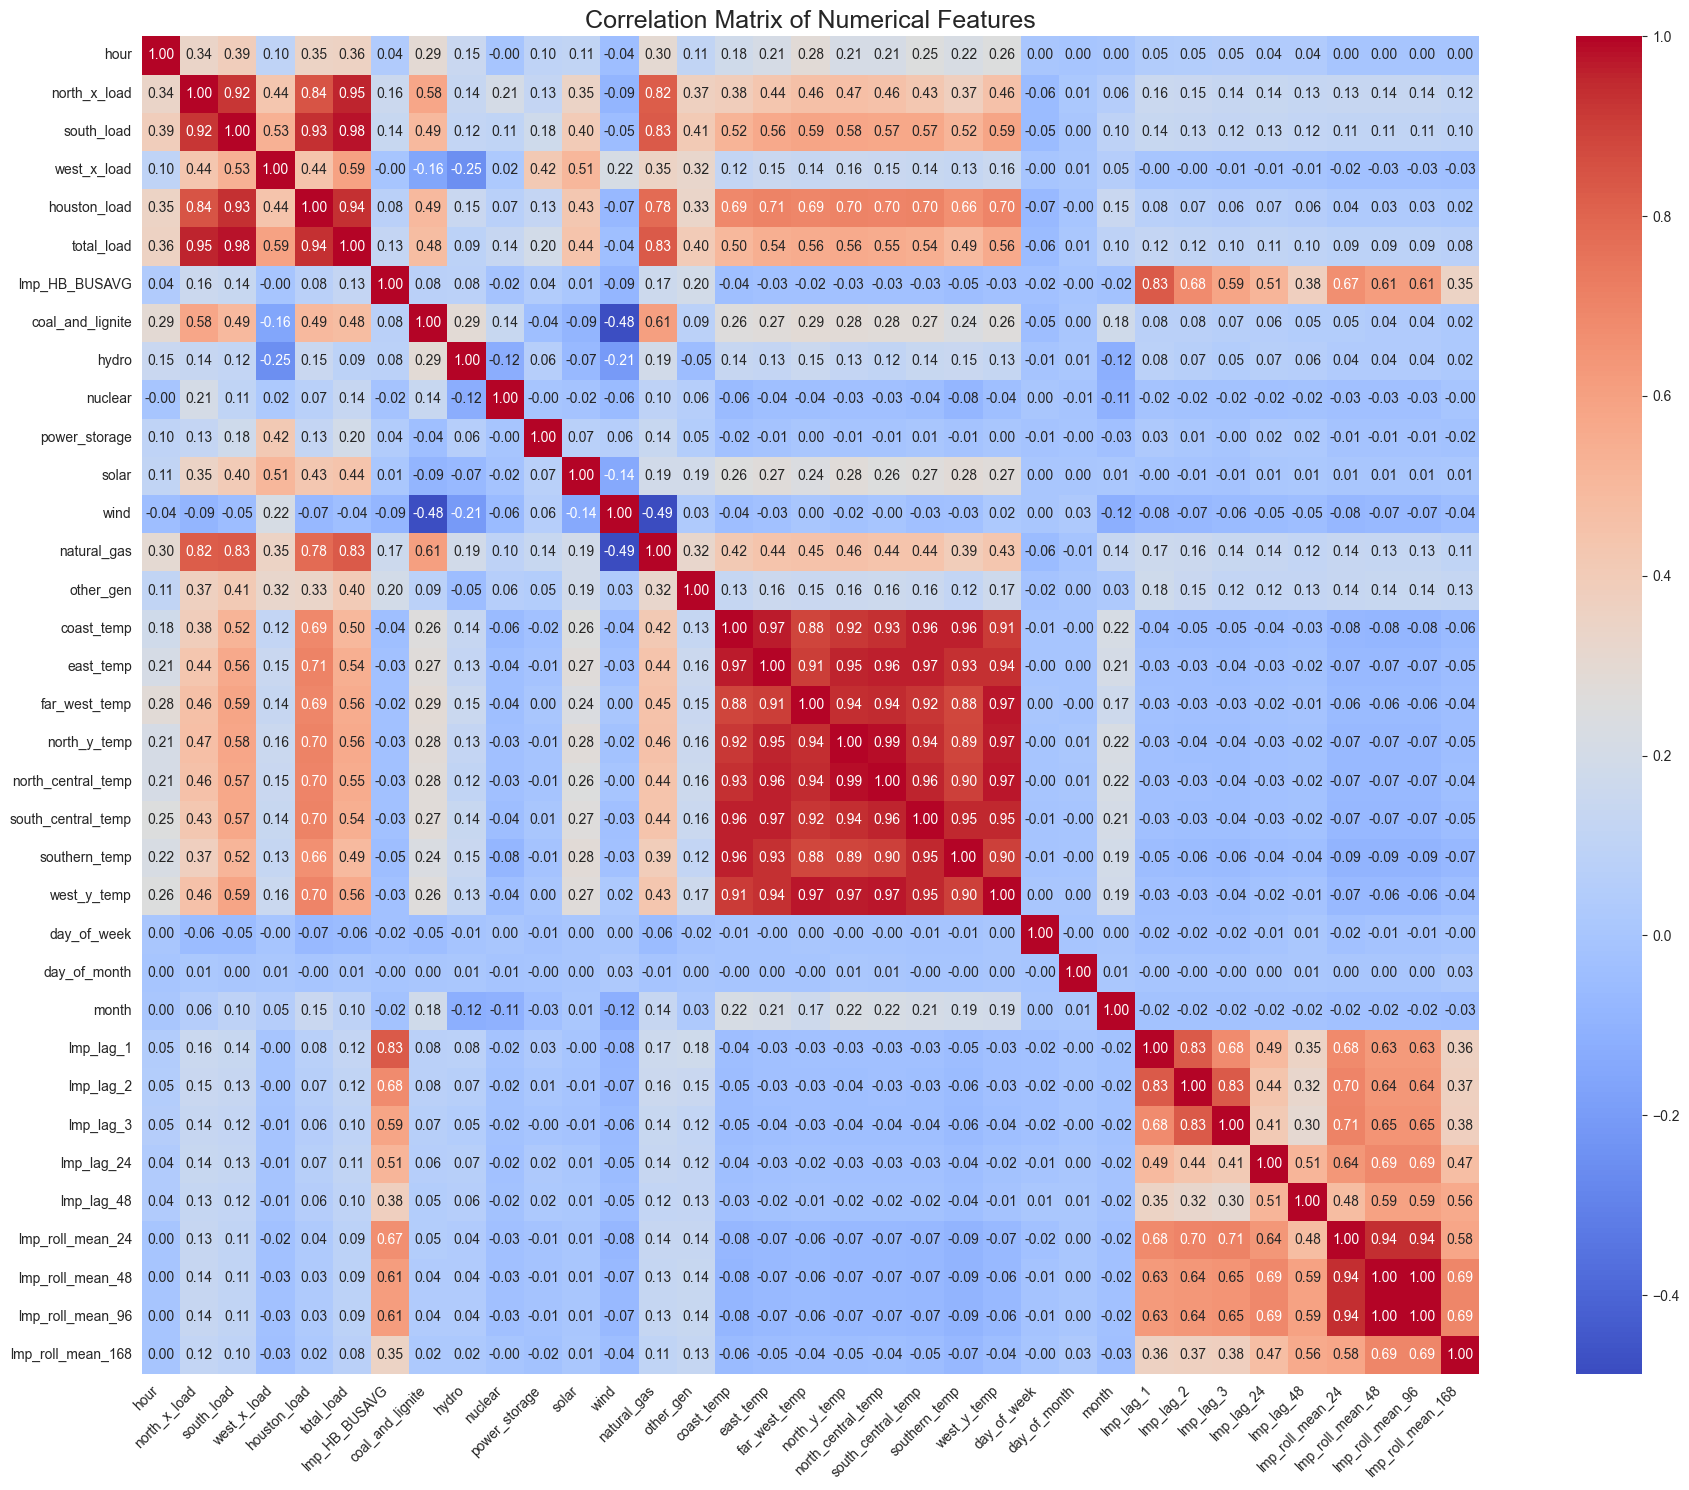

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#
numerical_columns = df.select_dtypes(include=[np.number])

#
correlation_matrix = numerical_columns.corr()

#
plt.figure(figsize=(20, 15))  #
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix of Numerical Features", fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()


## 1.3 Variable Importance

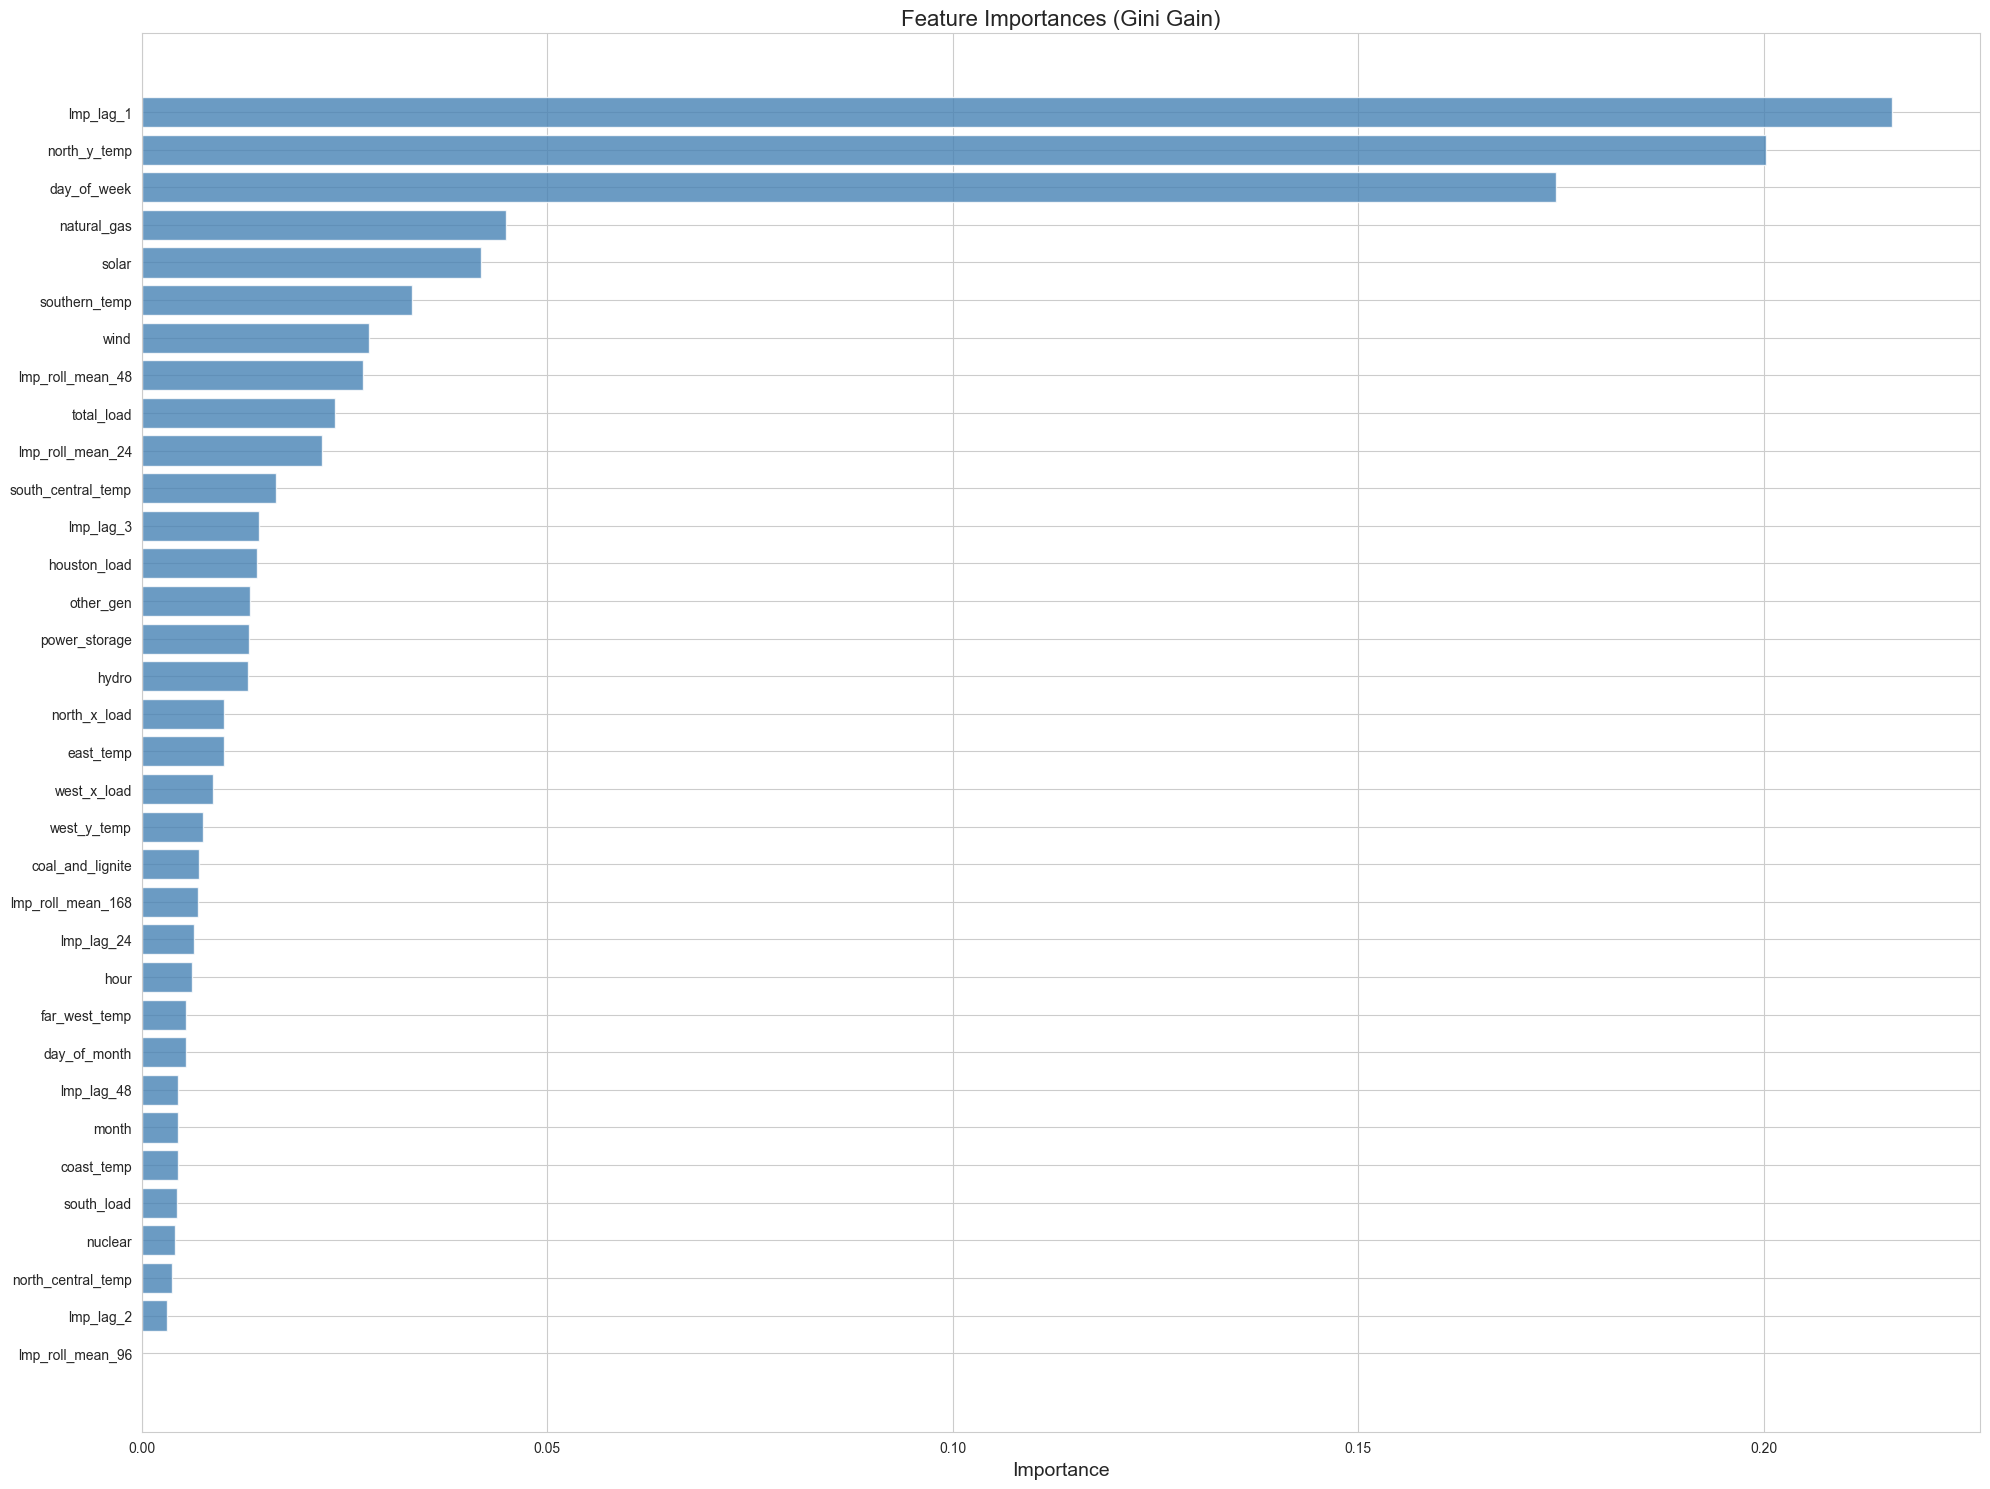

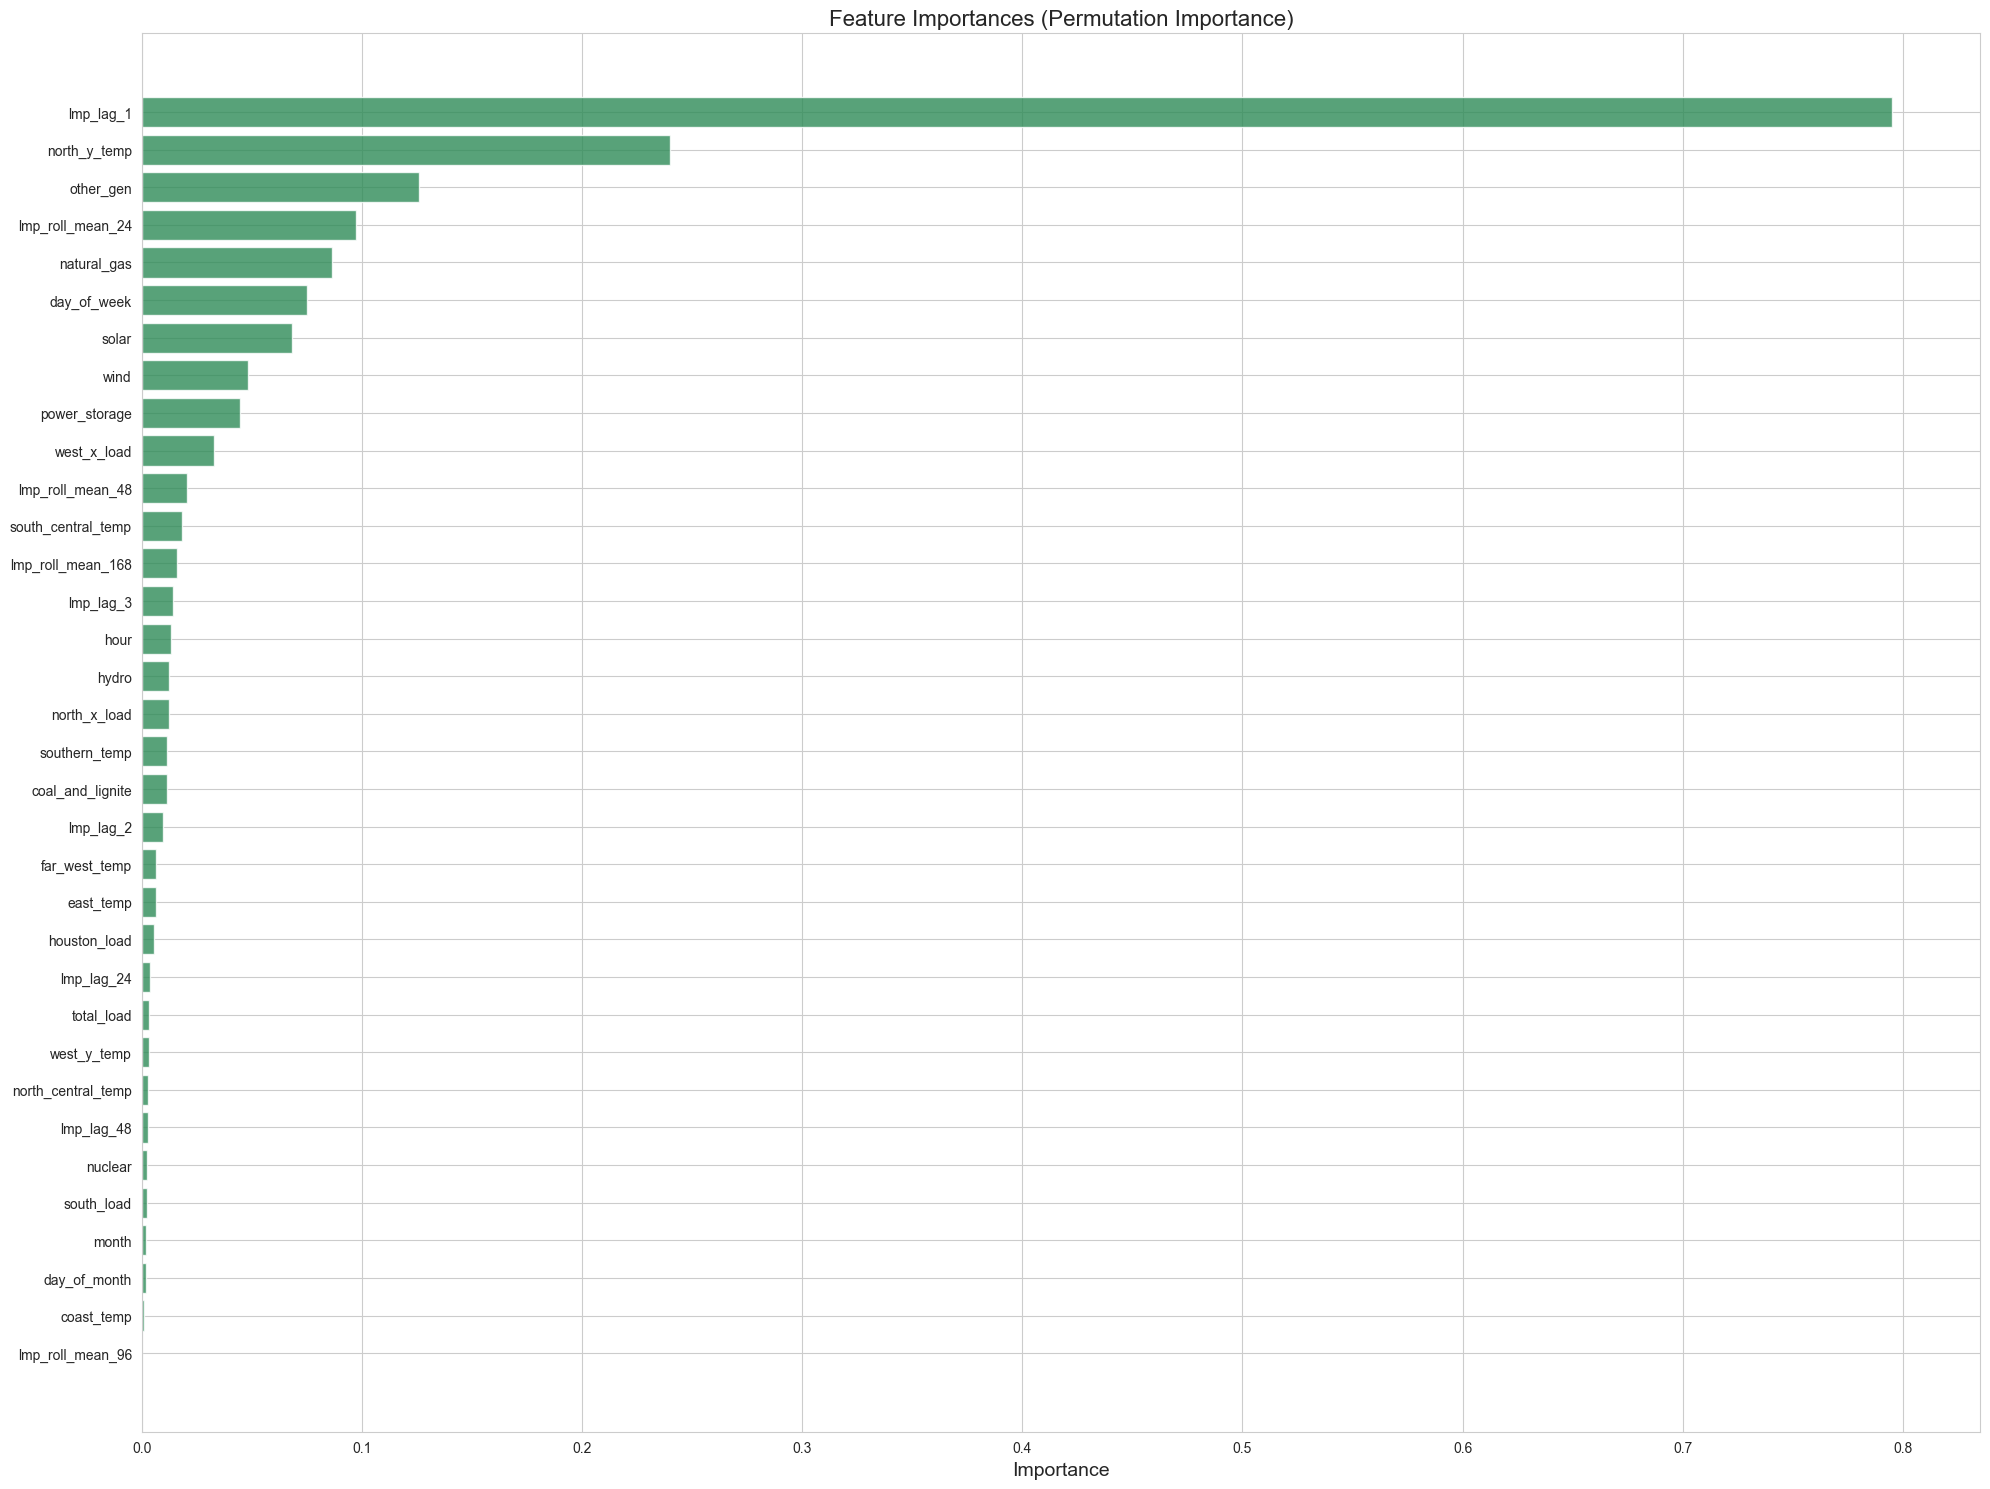

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance


target = df['lmp_HB_BUSAVG']

features = df.drop(columns=['lmp_HB_BUSAVG', 'interval_start_local'])
features = features.select_dtypes(include=[np.number])

model = XGBRegressor(random_state=42, n_estimators=500, learning_rate=0.05)
model.fit(features, target)


gini_importance = model.feature_importances_

#  Permutation Importance
perm_importance = permutation_importance(model, features, target, n_repeats=10, random_state=42)


sorted_idx_gini = np.argsort(gini_importance)[::-1]
features_sorted_gini = features.columns[sorted_idx_gini]
gini_sorted = gini_importance[sorted_idx_gini]


sorted_idx_perm = perm_importance.importances_mean.argsort()[::-1]
features_sorted_perm = features.columns[sorted_idx_perm]
perm_sorted = perm_importance.importances_mean[sorted_idx_perm]


plt.figure(figsize=(20, 15))
plt.barh(features_sorted_gini, gini_sorted, color="steelblue", alpha=0.8)
plt.gca().invert_yaxis()
plt.title("Feature Importances (Gini Gain)", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.tight_layout()
plt.savefig("figure/gini_gain_importance.png", dpi=300)
plt.show()


plt.figure(figsize=(20, 15))
plt.barh(features_sorted_perm, perm_sorted, color="seagreen", alpha=0.8)
plt.gca().invert_yaxis()
plt.title("Feature Importances (Permutation Importance)", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.tight_layout()
plt.savefig("figure/permutation_importance.png", dpi=300)
plt.show()


# 2 Train-test Split

## 2.1 Feature Engineering

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('../data/02_processed/all_hourly_data_v2.csv', low_memory=False)

# rename column
df.rename(columns={'Hub Average LMP': 'lmp_HB_BUSAVG'}, inplace=True)

# target variable
df['target_24h'] = df['lmp_HB_BUSAVG'].shift(-24)
df['target_1w'] = df['lmp_HB_BUSAVG'].shift(-168)

# predictive variable
df['Wet Bulb Temp'] = pd.to_numeric(df['Wet Bulb Temp'], errors='coerce')
df['interval_start_local'] = pd.to_datetime(df['interval_start_local'], utc=True)

df['hour']         = df['interval_start_local'].dt.hour
df['day_of_week']  = df['interval_start_local'].dt.dayofweek
df['day_of_month'] = df['interval_start_local'].dt.day
df['month']        = df['interval_start_local'].dt.month

#
df['hour_sin'] = np.sin(2 * np.pi * df['hour']        / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']        / 24)
df['dow_sin']  = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos']  = np.cos(2 * np.pi * df['day_of_week'] / 7)


# Lag Features
for lag in [1, 2, 3, 24, 48]:
    df[f'lmp_lag_{lag}'] = df['lmp_HB_BUSAVG'].shift(lag)

# Rolling Features
df['lmp_roll_mean_24'] = df['lmp_HB_BUSAVG'].rolling(window=24).mean()
df['lmp_roll_mean_48'] = df['lmp_HB_BUSAVG'].rolling(window=48).mean()
df['lmp_roll_mean_96'] = df['lmp_HB_BUSAVG'].rolling(window=96).mean()
df['lmp_roll_mean_168'] = df['lmp_HB_BUSAVG'].rolling(window=168).mean()


df = df.dropna().reset_index(drop=True)


## 2.2 Train-test Split

In [78]:
import pandas as pd


train_start = pd.Timestamp('2018-01-08 06:00:00+0000', tz='UTC')
train_end   = pd.Timestamp('2023-12-31 23:59:59+0000', tz='UTC')
test_start  = pd.Timestamp('2024-01-01 00:00:00+0000', tz='UTC')
test_end    = pd.Timestamp('2025-04-13 04:00:00+0000', tz='UTC')



#
mask_train = (df['interval_start_local'] >= train_start) & (df['interval_start_local'] <= train_end)
mask_test  = (df['interval_start_local'] >= test_start)  & (df['interval_start_local'] <= test_end)

#
train_df = df.loc[mask_train].reset_index(drop=True)
test_df  = df.loc[mask_test].reset_index(drop=True)

#
print(f"training samples: {train_df.shape[0]}, features: {train_df.shape[1]}")
print(f"testing samples：{test_df.shape[0]}, features:{test_df.shape[1]}")


training samples: 52325, features: 45
testing samples：10998, features:45


# 3.Hour-ahead forecasting

## 3.1 Xgboost

### 3.1.1 baseline model

Test MSE:  4578.6397
Test RMSE: 67.6656
Test MAE:  27.9068


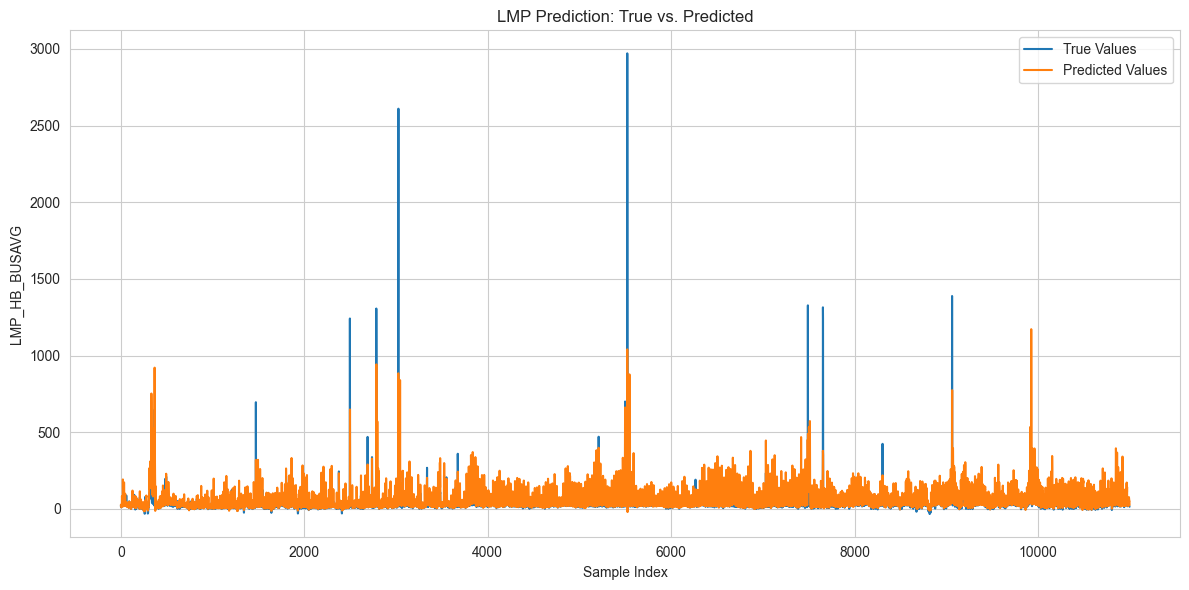

In [52]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Prepare feature matrix and target vector
exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG']
features = [col for col in train_df.columns if col not in exclude_cols]

X_train, y_train = train_df[features], train_df['lmp_HB_BUSAVG']
X_test,  y_test  = test_df[features],  test_df['lmp_HB_BUSAVG']

# Train XGBoost regressor
model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

# 6. Make predictions
y_pred = model.predict(X_test)

# 7. Compute evaluation metrics
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")

# 8. Plot true vs. predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values')
plt.plot(y_pred,         label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('LMP_HB_BUSAVG')
plt.title('LMP Prediction: True vs. Predicted')
plt.legend()
plt.tight_layout()
plt.show()

### 3.1.2 feature importance

                             feature  importance
33                         lmp_lag_1    0.209460
18                North Central Temp    0.114846
34                         lmp_lag_2    0.057434
17                        North Temp    0.053959
29                          hour_sin    0.052047
14                        Coast Temp    0.045648
31                           dow_sin    0.038401
12                       natural_gas    0.034095
38                  lmp_roll_mean_24    0.033049
19                South Central Temp    0.032343
26                       day_of_week    0.031821
15                         East Temp    0.030565
20                     Southern Temp    0.025711
11                              wind    0.022884
10                             solar    0.019263
24                        target_24h    0.015731
25                         target_1w    0.014623
13                             other    0.012876
7                              hydro    0.011146
23  Henry Hub Natura

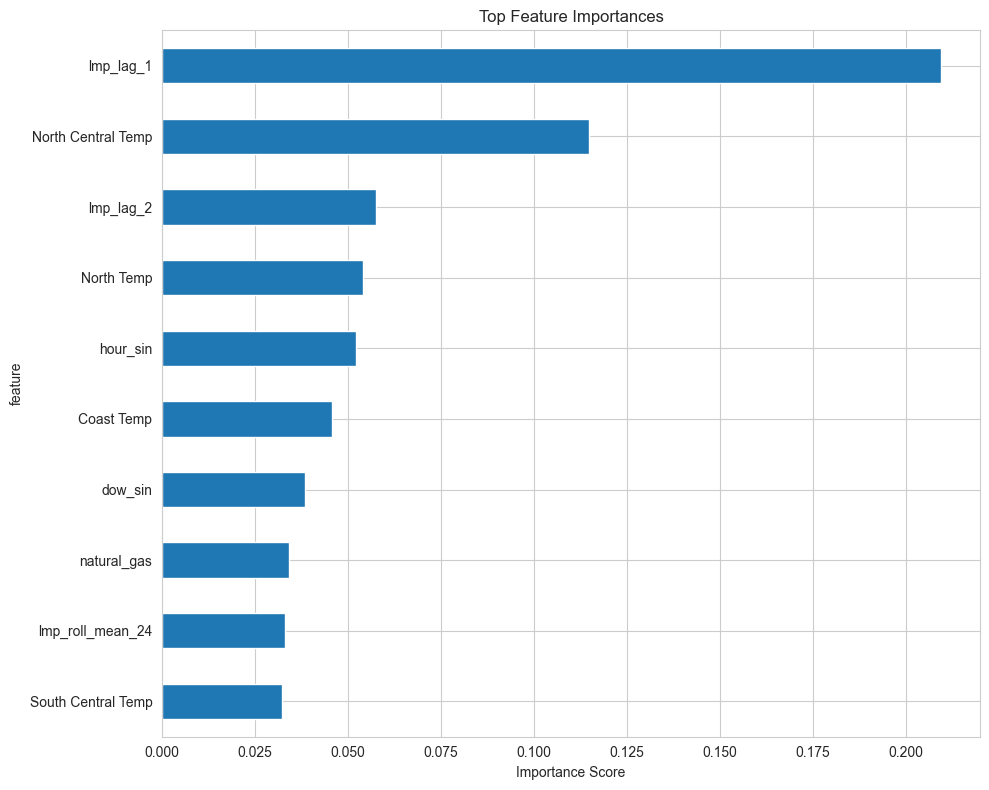

In [53]:
importances = model.feature_importances_

importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

# Plot top 10
top_n = 10
importance_df.head(top_n).plot(kind='barh', x='feature', y='importance', figsize=(10, 8), legend=False)
plt.title("Top Feature Importances")
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

                             feature   importance
38                  lmp_roll_mean_24  1151.118514
41                 lmp_roll_mean_168   447.264982
10                             solar   412.790697
9                      power_storage   355.394579
6                   coal_and_lignite   348.629262
23  Henry Hub Natural Gas Spot Price   338.336161
39                  lmp_roll_mean_48   325.137272
35                         lmp_lag_3   231.407104
21                         West Temp   157.679618
12                       natural_gas   146.264166
36                        lmp_lag_24   143.703790
2                         South Load   142.814700
13                             other   135.045482
1                         North Load   120.969916
15                         East Temp   102.285016
34                         lmp_lag_2    94.774391
18                North Central Temp    89.577990
5                         Total Load    87.739072
0                               hour    82.306717


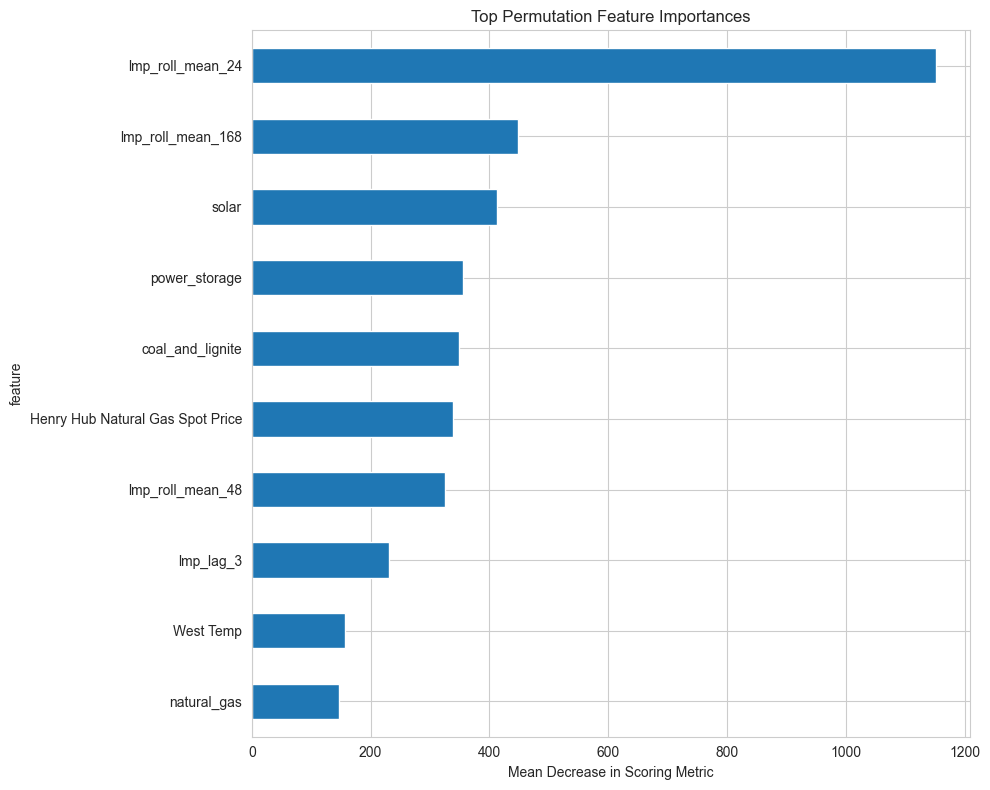

In [54]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt


result = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_mean_squared_error'
)


perm_df = pd.DataFrame({
    'feature': X_test.columns,

    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)


print(perm_df)


top_n = 10
perm_df.head(top_n).plot(
    kind='barh',
    x='feature',
    y='importance',
    figsize=(10, 8),
    legend=False
)
plt.title("Top Permutation Feature Importances")
plt.gca().invert_yaxis()
plt.xlabel("Mean Decrease in Scoring Metric")
plt.tight_layout()
plt.show()


### 3.1.3 Rolling-Origin Validation

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna
import logging


optuna.logging.set_verbosity(optuna.logging.WARNING)

# optuna.logging.set_verbosity(optuna.logging.CRITICAL)

#
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

def objective(trial):
    params = {
        "n_estimators":     trial.suggest_int("n_estimators", 100, 1000),
        "max_depth":        trial.suggest_int("max_depth", 3, 12),
        "learning_rate":    trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample":        trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma":            trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha":        trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda":       trial.suggest_float("reg_lambda", 0.0, 5.0),
        "verbosity":        0,
        "random_state":     42,
        "objective":        "reg:squarederror",
        "eval_metric":      "rmse",
    }

    fold_rmse = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        preds = model.predict(X_val)
        fold_rmse.append(np.sqrt(mean_squared_error(y_val, preds)))

    return float(np.mean(fold_rmse))

study = optuna.create_study(
    direction="minimize",
    study_name="xgb_lmp_tuning_tsCV"
)
study.optimize(objective, n_trials=50, timeout=600)

print("Best CV RMSE: {:.4f}".format(study.best_value))
print("Best Params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")


Best CV RMSE: 193.8736
Best Params:
  n_estimators: 397
  max_depth: 11
  learning_rate: 0.011837146768969457
  subsample: 0.5057265900034111
  colsample_bytree: 0.6934739337152067
  gamma: 2.1159309826995605
  reg_alpha: 1.0718492861247824
  reg_lambda: 1.8956241695859577


### 3.1.4 Final_training

In [56]:
# u
best_params = study.best_params
final_model = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42,
    verbosity=0
)
final_model.fit(X_train, y_train, verbose=False)

#
y_pred = final_model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print(f"Final Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Final Test RMSE: 62.0054, MAE: 23.2819


### 3.1.5 Plotting Results

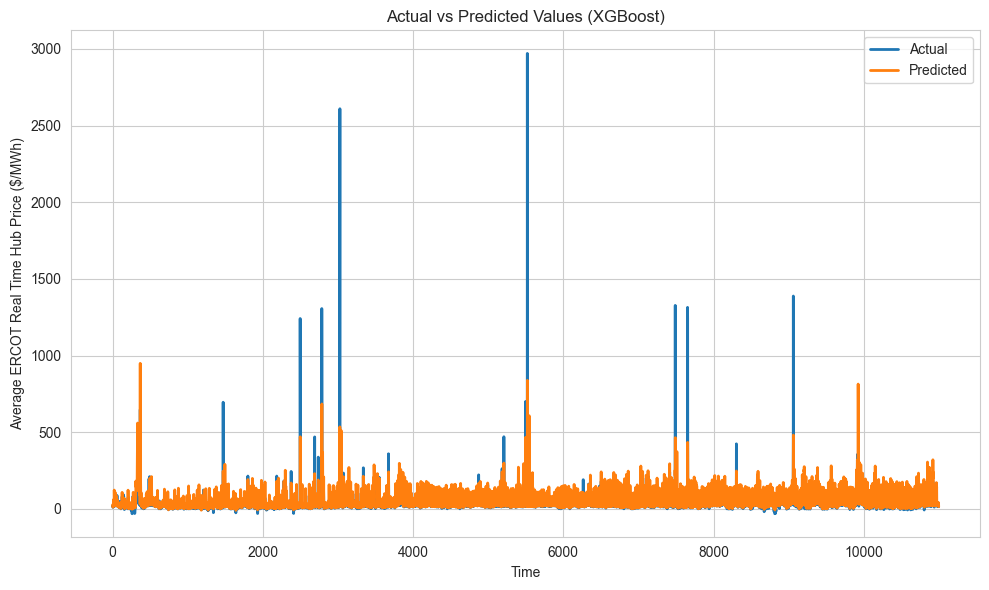

In [57]:
# Plot Actual vs Predicted over samples
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Values (XGBoost)')
plt.xlabel('Time')
plt.ylabel('Average ERCOT Real Time Hub Price ($/MWh)')
plt.legend()
plt.tight_layout()
plt.show()

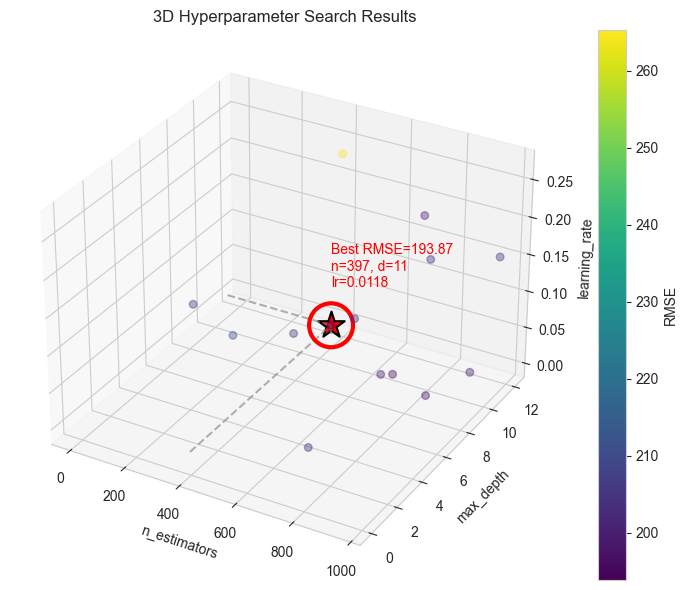

In [58]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#
xs   = [t.params["n_estimators"]      for t in study.trials]
ys   = [t.params["max_depth"]         for t in study.trials]
zs   = [t.params["learning_rate"]     for t in study.trials]
vals = [t.value                        for t in study.trials]  # RMSE

#
best = study.best_trial
xb, yb, zb = (best.params["n_estimators"],
              best.params["max_depth"],
              best.params["learning_rate"])
vb = best.value

fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection="3d")

#
ax.scatter(xs, ys, zs,
           c=vals, cmap="viridis",
           s=30, alpha=0.4)

#
ax.scatter([xb], [yb], [zb],
           c="red", marker="*", s=400,
           edgecolors="k", linewidths=1.5)

#
ax.scatter([xb], [yb], [zb],
           facecolors='none', edgecolors='red',
           s=1000, linewidths=3)

#
ax.plot([xb, xb], [yb, yb], [0, zb],
        linestyle="--", color="gray", alpha=0.6)
ax.plot([xb, xb], [0, yb], [zb, zb],
        linestyle="--", color="gray", alpha=0.6)
ax.plot([0, xb], [yb, yb], [zb, zb],
        linestyle="--", color="gray", alpha=0.6)

#
ax.text(xb, yb, zb + 0.05,
        f"Best RMSE={vb:.2f}\nn={xb}, d={yb}\nlr={zb:.3g}",
        color="red", fontsize=10, ha="left", va="bottom")

#
ax.set_xlabel("n_estimators")
ax.set_ylabel("max_depth")
ax.set_zlabel("learning_rate")
ax.set_title("3D Hyperparameter Search Results")

mappable = plt.cm.ScalarMappable(cmap="viridis")
mappable.set_array(vals)
fig.colorbar(mappable, ax=ax, label="RMSE")

plt.tight_layout()
plt.show()


## 3.2 Lightgbm

### 3.2.1 baseline model

In [59]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG']
features = [c for c in train_df.columns if c not in exclude_cols]

X_train, y_train = train_df[features], train_df['lmp_HB_BUSAVG']
X_test,  y_test  = test_df[features],  test_df['lmp_HB_BUSAVG']

#
model = lgb.LGBMRegressor(
    objective='regression',   #
    metric='rmse',            #
    num_leaves=31,            #
    learning_rate=0.05,       #
    n_estimators=500,         #
    subsample=0.8,            #
    colsample_bytree=0.8,     #
    random_state=42
)

#
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse'
)

#
y_pred = model.predict(X_test)

#
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")


 MSE:  5744.4828
RMSE: 75.7924
 MAE:  29.4927


### 3.2.2 feature importance

               feature  importance
17        north_y_temp        1209
31           lmp_lag_1        1089
19  south_central_temp         869
15           east_temp         838
13           other_gen         831
36    lmp_roll_mean_24         816
16       far_west_temp         758
9        power_storage         528
22          target_24h         499
32           lmp_lag_2         498
11                wind         449
12         natural_gas         436
7                hydro         426
33           lmp_lag_3         395
18  north_central_temp         361
10               solar         349
3          west_x_load         338
14          coast_temp         333
6     coal_and_lignite         324
23           target_1w         324
20       southern_temp         324
34          lmp_lag_24         312
35          lmp_lag_48         309
21         west_y_temp         283
37    lmp_roll_mean_48         256
0                 hour         212
39   lmp_roll_mean_168         203
1         north_x_lo

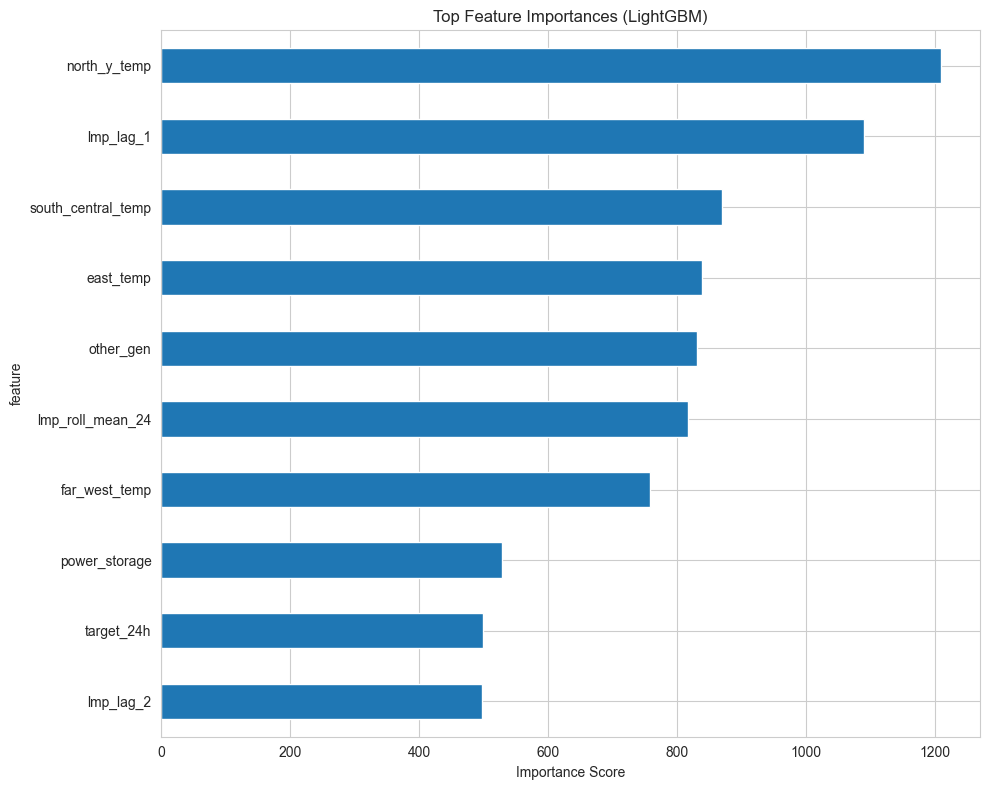

In [15]:
importances = model.feature_importances_

importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

top_n = 10
importance_df.head(top_n).plot(kind='barh', x='feature', y='importance', figsize=(10, 8), legend=False)
plt.title("Top Feature Importances (LightGBM)")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

               feature  importance
9        power_storage  768.414235
31           lmp_lag_1  515.756975
19  south_central_temp  380.528444
36    lmp_roll_mean_24  355.938869
10               solar  189.422057
12         natural_gas  183.951389
32           lmp_lag_2  132.177426
3          west_x_load  112.770024
17        north_y_temp   98.109154
18  north_central_temp   77.993997
37    lmp_roll_mean_48   57.594969
5           total_load   56.154827
2           south_load   55.439967
14          coast_temp   48.889013
34          lmp_lag_24   31.864089
6     coal_and_lignite   30.976930
8              nuclear   29.830247
39   lmp_roll_mean_168   26.377262
1         north_x_load   25.804889
26               month   20.500454
20       southern_temp   20.190443
29             dow_sin   10.014465
33           lmp_lag_3    7.089574
24         day_of_week    2.059091
30             dow_cos   -0.423397
25        day_of_month   -0.579794
4         houston_load   -2.805474
38    lmp_roll_mean_

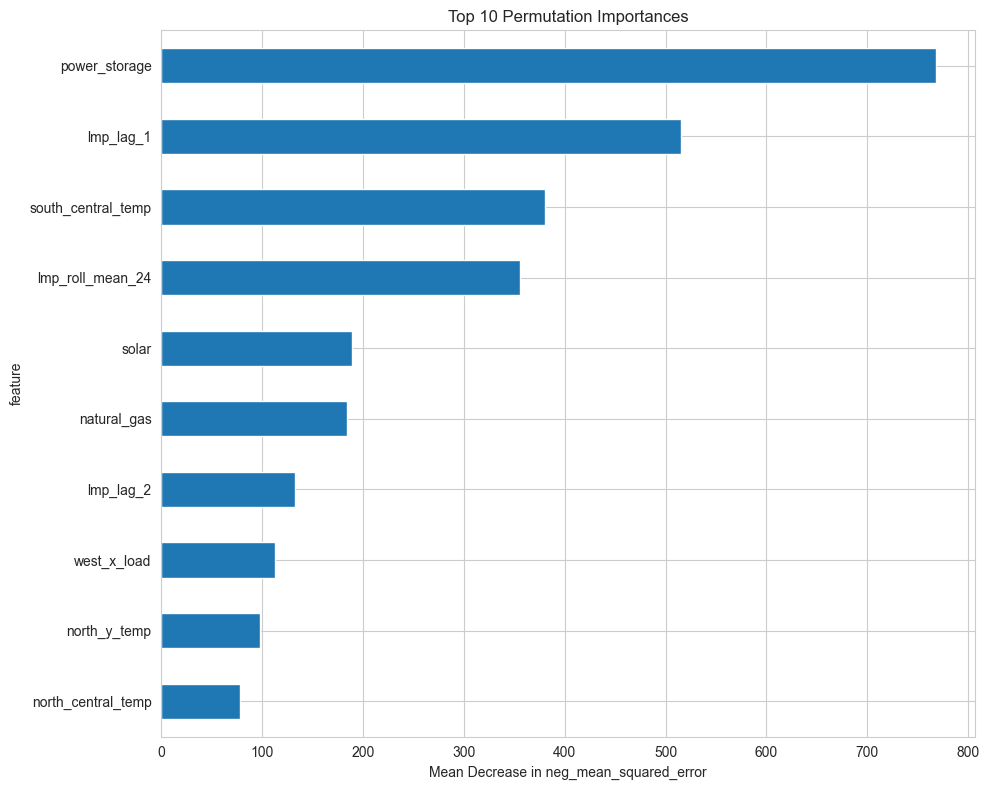

In [16]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# permutation importance
result = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_mean_squared_error'
)


perm_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

print(perm_df)


top_n = 10
perm_df.head(top_n).plot(
    kind='barh',
    x='feature',
    y='importance',
    figsize=(10, 8),
    legend=False
)
plt.title(f"Top {top_n} Permutation Importances")
plt.gca().invert_yaxis()
plt.xlabel("Mean Decrease in neg_mean_squared_error")
plt.tight_layout()
plt.show()


### 3.2.3 Rolling-Origin Validation

In [60]:
import logging
import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

# turn off Optuna's INFO logs (including the "Best is trial..." summary)
optuna.logging.set_verbosity(logging.WARNING)

n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

def objective(trial):
    params = {
        "objective":         "regression",
        "metric":            "rmse",
        "num_leaves":        trial.suggest_int("num_leaves", 20, 150),
        "max_depth":         trial.suggest_int("max_depth", 3, 12),
        "learning_rate":     trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_split_gain":    trial.suggest_float("min_split_gain", 0.0, 5.0),
        "subsample":         trial.suggest_float("subsample", 0.5, 1.0),
        "subsample_freq":    trial.suggest_int("subsample_freq", 1, 10),
        "colsample_bytree":  trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha":         trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda":        trial.suggest_float("reg_lambda", 0.0, 5.0),
        "verbosity":        -1,
        "random_state":      42
    }

    fold_rmse = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        gbm = lgb.LGBMRegressor(**params, n_estimators=1000)
        gbm.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.log_evaluation(0)]
        )
        preds = gbm.predict(X_val)
        fold_rmse.append(np.sqrt(mean_squared_error(y_val, preds)))

    return float(np.mean(fold_rmse))

study = optuna.create_study(direction="minimize", study_name="lgb_lmp_tuning_tsCV")
study.optimize(objective, n_trials=50, timeout=600)

# only print the final CV RMSE
print(f"Best CV RMSE: {study.best_value:.4f}")
print("Best Params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")


Best CV RMSE: 183.1986
Best Params:
  num_leaves: 83
  max_depth: 7
  learning_rate: 0.06130905041421802
  min_child_samples: 68
  min_split_gain: 2.8301225089559203
  subsample: 0.8311164228876664
  subsample_freq: 1
  colsample_bytree: 0.9751748221902709
  reg_alpha: 4.560242213953798
  reg_lambda: 4.285856050248616


### 3.2.4 Full Training

In [61]:

best_params = study.best_params
final_model = lgb.LGBMRegressor(
    **best_params,
    random_state=42,
    verbosity=-1
)

final_model.fit(X_train, y_train)


y_pred = final_model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
print(f"Final Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Final Test RMSE: 79.7246, MAE: 31.8768


### 3.2.5 Plotting Results

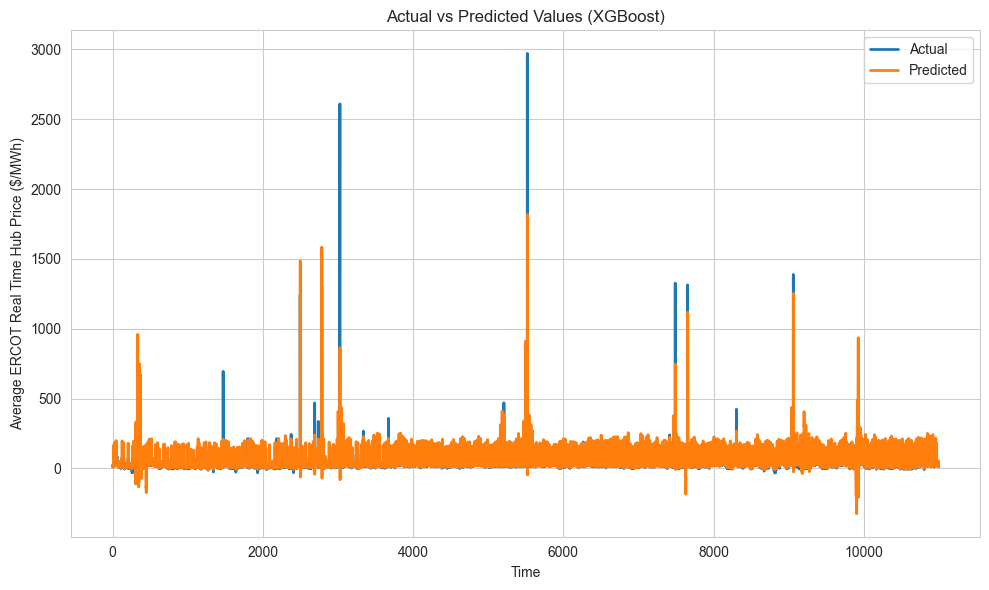

In [62]:
# Plot Actual vs Predicted over samples
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Values (XGBoost)')
plt.xlabel('Time')
plt.ylabel('Average ERCOT Real Time Hub Price ($/MWh)')
plt.legend()
plt.tight_layout()
plt.show()

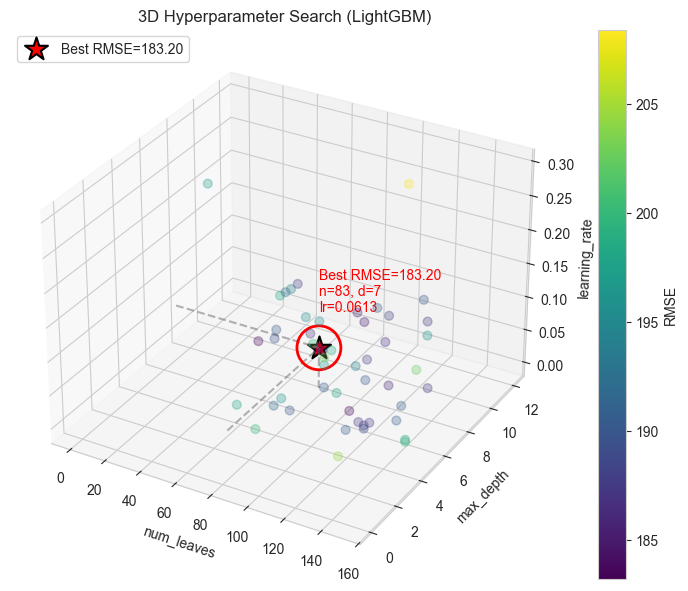

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#
xs   = [t.params["num_leaves"]       for t in study.trials]
ys   = [t.params["max_depth"]        for t in study.trials]
zs   = [t.params["learning_rate"]    for t in study.trials]
vals = [t.value                       for t in study.trials]  # RMSE

#
best = study.best_trial
xb, yb, zb = (
    best.params["num_leaves"],
    best.params["max_depth"],
    best.params["learning_rate"]
)
vb = best.value  #

fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111, projection="3d")

#
ax.scatter(xs, ys, zs,
           c=vals,
           cmap="viridis",
           s=40,
           alpha=0.3)

#
ax.scatter([xb], [yb], [zb],
           c="red",
           marker="*",
           s=300,
           edgecolors="k",
           linewidths=1.5,
           label=f"Best RMSE={vb:.2f}")

#
ax.scatter([xb], [yb], [zb],
           facecolors="none",
           edgecolors="red",
           s=1000,
           linewidths=2)

#
ax.plot([xb, xb], [yb, yb], [0, zb],
        linestyle="--", color="gray", alpha=0.6)
ax.plot([xb, xb], [0, yb], [zb, zb],
        linestyle="--", color="gray", alpha=0.6)
ax.plot([0, xb], [yb, yb], [zb, zb],
        linestyle="--", color="gray", alpha=0.6)

#

ax.text(xb, yb, zb + 0.05,
        f"Best RMSE={vb:.2f}\nn={xb}, d={yb}\nlr={zb:.3g}",
        color="red", fontsize=10, ha="left", va="bottom")

#
ax.set_xlabel("num_leaves")
ax.set_ylabel("max_depth")
ax.set_zlabel("learning_rate")
ax.set_title("3D Hyperparameter Search (LightGBM)")

#
mappable = plt.cm.ScalarMappable(cmap="viridis")
mappable.set_array(vals)
fig.colorbar(mappable, ax=ax, label="RMSE")
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()


# 4. RNNs

## 4.1 LSTM

### 4.1.1 baseline model

In [64]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_all = scaler_x.fit_transform(train_df[feature_cols])
y_train_all = scaler_y.fit_transform(train_df[['lmp_HB_BUSAVG']])
X_test_all  = scaler_x.transform(test_df[feature_cols])
y_test_all  = scaler_y.transform(test_df[['lmp_HB_BUSAVG']])

#
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24):
        self.X, self.y, self.seq_len = X, y, seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]
        y_seq = self.y[idx+self.seq_len]
        return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq)

seq_len = 24
train_ds = TimeSeriesDataset(X_train_all, y_train_all, seq_len)
test_ds  = TimeSeriesDataset(X_test_all,  y_test_all,  seq_len)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

#
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, seq_len, n_features]
        out, _ = self.lstm(x)         # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]           #
        return self.fc(out)           # [batch, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = LSTMRegressor(n_features=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#
n_epochs = 20
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        y_pred = model(xb).squeeze(1)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs}, Train MSE={avg_loss:.6f}")


model.eval()
ys, preds = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1,1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1,1))


mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")


C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([13, 1])) that is different to the input size (torch.Size([13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Train MSE=0.000632
Epoch 2/20, Train MSE=0.000610
Epoch 3/20, Train MSE=0.000607
Epoch 4/20, Train MSE=0.000603
Epoch 5/20, Train MSE=0.000603
Epoch 6/20, Train MSE=0.000602
Epoch 7/20, Train MSE=0.000600
Epoch 8/20, Train MSE=0.000600
Epoch 9/20, Train MSE=0.000600
Epoch 10/20, Train MSE=0.000600
Epoch 11/20, Train MSE=0.000600
Epoch 12/20, Train MSE=0.000600
Epoch 13/20, Train MSE=0.000600
Epoch 14/20, Train MSE=0.000600
Epoch 15/20, Train MSE=0.000600
Epoch 16/20, Train MSE=0.000600
Epoch 17/20, Train MSE=0.000600
Epoch 18/20, Train MSE=0.000600
Epoch 19/20, Train MSE=0.000600
Epoch 20/20, Train MSE=0.000600
 MSE:  4247.8398
RMSE: 65.1755
 MAE:  22.7976


###  4.1.2 LSTM Feature Importance

Permutation importance: shuffle one feature at a time in the test set, measure drop in performance, larger drop = more important feature

In [65]:
from torch.utils.data import Subset

subset_len = int(0.2 * len(train_ds))
subset_idx = np.random.choice(np.arange(len(train_ds)), size=subset_len, replace=False)

subset_ds = Subset(train_ds, subset_idx)

subset_loader = DataLoader(subset_ds, batch_size=64, shuffle=False)
model.eval()
preds, ys = [], []
with torch.no_grad():
    for xb, yb in subset_loader:
        xb = xb.to(device)
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1, 1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1, 1))
base_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Base RMSE: {base_rmse:.4f}")

def permute_and_score(model, dataset, feature_idx, base_rmse, scaler_y, device):
    # Handle Subset or original TimeSeriesDataset
    if isinstance(dataset, torch.utils.data.Subset):
        base_ds = dataset.dataset
        indices = dataset.indices
        X = base_ds.X[indices].copy()
        y = base_ds.y[indices].copy()
    else:
        X = dataset.X.copy()
        y = dataset.y.copy()

    # Permute the selected feature column
    np.random.shuffle(X[:, feature_idx])

    perm_ds = TimeSeriesDataset(X, y, seq_len=24)
    loader = DataLoader(perm_ds, batch_size=64, shuffle=False)

    model.eval()
    preds, ys = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            y_pred = model(xb).squeeze(1).cpu().numpy()
            preds.append(y_pred)
            ys.append(yb.numpy())

    y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse - base_rmse

from joblib import Parallel, delayed

importances = Parallel(n_jobs=-1)(
    delayed(permute_and_score)(model, subset_ds, i, base_rmse, scaler_y, device)
    for i in range(len(feature_cols))
)

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'rmse_increase': importances
}).sort_values(by='rmse_increase', ascending=False)

print(importance_df)


Base RMSE: 220.4357
                             feature  rmse_increase
31                           dow_sin     -18.896336
29                          hour_sin     -18.897848
35                         lmp_lag_3     -18.897896
32                           dow_cos     -18.898148
6                   coal_and_lignite     -18.898245
8                            nuclear     -18.898274
1                         North Load     -18.898342
4                       Houston Load     -18.898458
30                          hour_cos     -18.898487
13                             other     -18.898497
9                      power_storage     -18.898507
25                         target_1w     -18.898536
7                              hydro     -18.898575
5                         Total Load     -18.898662
2                         South Load     -18.898875
37                        lmp_lag_48     -18.898904
23  Henry Hub Natural Gas Spot Price     -18.898982
3                          West Load     -18

### 4.1.3 hyperparameter tuning

In [28]:
import numpy as np
import torch
import optuna

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


# X_train_all: np.ndarray, shape=(n_samples, n_features)
# y_train_all: np.ndarray, shape=(n_samples, 1)
# scaler_y:    sklearn.preprocessing.MinMaxScaler

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq    = self.X[idx:idx + self.seq_len]
        y_target = self.y[idx + self.seq_len]
        return torch.FloatTensor(x_seq), torch.FloatTensor(y_target)

class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)       # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]         #
        return self.fc(out)         # [batch, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tscv   = TimeSeriesSplit(n_splits=3)

def objective(trial):
    #
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    num_layers  = trial.suggest_int("num_layers", 1, 3)
    lr          = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size  = trial.suggest_categorical("batch_size", [32, 64, 128])
    seq_len     = trial.suggest_int("seq_len", 12, 48, step=12)
    n_epochs    = trial.suggest_int("n_epochs", 5, 30)

    fold_rmse = []

    for train_idx, val_idx in tscv.split(X_train_all):
        X_tr, X_val = X_train_all[train_idx], X_train_all[val_idx]
        y_tr, y_val = y_train_all[train_idx], y_train_all[val_idx]

        train_ds = TimeSeriesDataset(X_tr, y_tr, seq_len)
        val_ds   = TimeSeriesDataset(X_val, y_val, seq_len)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

        model     = LSTMRegressor(
                        n_features=X_tr.shape[1],
                        hidden_size=hidden_size,
                        num_layers=num_layers
                    ).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        #
        for epoch in range(n_epochs):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()

                y_pred = model(xb).squeeze(1)    # [batch]
                y_true = yb.squeeze(1)           # [batch]
                loss   = criterion(y_pred, y_true)

                loss.backward()
                optimizer.step()

        #
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                out = model(xb).squeeze(1).cpu().numpy()
                preds.append(out)
                trues.append(yb.numpy())

        #
        y_pred_inv = scaler_y.inverse_transform(
                        np.concatenate(preds).reshape(-1, 1)
                     )
        y_true_inv = scaler_y.inverse_transform(
                        np.concatenate(trues).reshape(-1, 1)
                     )
        rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
        fold_rmse.append(rmse)

    return float(np.mean(fold_rmse))

#
study = optuna.create_study(
    direction="minimize",
    study_name="lstm_lmp_tuning"
)
study.optimize(objective, n_trials=50, timeout=600)

#
print(f"Best CV RMSE: {study.best_value:.4f}")
print("Best hyperparameters:")
for key, val in study.best_params.items():
    print(f"  {key}: {val}")


C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([37, 1])) that is different to the input size (torch.Size([37])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Train MSE=1.001506
Epoch 2/20, Train MSE=1.000933
Epoch 3/20, Train MSE=1.000788
Epoch 4/20, Train MSE=1.000645
Epoch 5/20, Train MSE=1.000575
Epoch 6/20, Train MSE=1.000491
Epoch 7/20, Train MSE=1.000567
Epoch 8/20, Train MSE=1.000455
Epoch 9/20, Train MSE=1.000593
Epoch 10/20, Train MSE=1.000489
Epoch 11/20, Train MSE=1.000509
Epoch 12/20, Train MSE=1.000449
Epoch 13/20, Train MSE=1.000524
Epoch 14/20, Train MSE=1.000502
Epoch 15/20, Train MSE=1.000442
Epoch 16/20, Train MSE=1.000439
Epoch 17/20, Train MSE=1.000433
Epoch 18/20, Train MSE=1.000473
Epoch 19/20, Train MSE=1.000404
Epoch 20/20, Train MSE=1.000446
Test MSE:  4525.3906
Test RMSE: 67.2710
Test MAE:  23.4316


## 4.2 GRU

### 4.2.1 baseline model

In [66]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_all = scaler_x.fit_transform(train_df[feature_cols])
y_train_all = scaler_y.fit_transform(train_df[['lmp_HB_BUSAVG']])
X_test_all  = scaler_x.transform(test_df[feature_cols])
y_test_all  = scaler_y.transform(test_df[['lmp_HB_BUSAVG']])

#
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24):
        self.X, self.y, self.seq_len = X, y, seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]
        y_seq = self.y[idx+self.seq_len]
        return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq)

seq_len = 24
train_ds = TimeSeriesDataset(X_train_all, y_train_all, seq_len)
test_ds  = TimeSeriesDataset(X_test_all,  y_test_all,  seq_len)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

#
class GRURegressor(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_size=n_features,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        return self.fc(out)

device = torch.device('cpu')
model  = GRURegressor(n_features=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#
n_epochs = 20
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        y_pred = model(xb).squeeze(1)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs}, Train MSE={avg_loss:.6f}")

#
model.eval()
ys, preds = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1,1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1,1))

#
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")

C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([13, 1])) that is different to the input size (torch.Size([13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Train MSE=0.000905
Epoch 2/20, Train MSE=0.000631
Epoch 3/20, Train MSE=0.000622
Epoch 4/20, Train MSE=0.000617
Epoch 5/20, Train MSE=0.000616
Epoch 6/20, Train MSE=0.000615
Epoch 7/20, Train MSE=0.000609
Epoch 8/20, Train MSE=0.000610
Epoch 9/20, Train MSE=0.000609
Epoch 10/20, Train MSE=0.000606
Epoch 11/20, Train MSE=0.000604
Epoch 12/20, Train MSE=0.000603
Epoch 13/20, Train MSE=0.000603
Epoch 14/20, Train MSE=0.000604
Epoch 15/20, Train MSE=0.000601
Epoch 16/20, Train MSE=0.000602
Epoch 17/20, Train MSE=0.000601
Epoch 18/20, Train MSE=0.000600
Epoch 19/20, Train MSE=0.000600
Epoch 20/20, Train MSE=0.000600
 MSE:  5892.4424
RMSE: 76.7622
 MAE:  49.3625


### 4.2.2 GRU Feature Importance

In [67]:
# Take a 20% random sample from training data
subset_len = int(0.2 * len(train_ds))
subset_idx = np.random.choice(np.arange(len(train_ds)), size=subset_len, replace=False)

subset_ds = Subset(train_ds, subset_idx)
subset_loader = DataLoader(subset_ds, batch_size=64, shuffle=False)

model.eval()
ys, preds = [], []
with torch.no_grad():
    for xb, yb in subset_loader:
        xb = xb.to(device)
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true_subset = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1, 1))
y_pred_subset = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1, 1))
base_rmse = np.sqrt(mean_squared_error(y_true_subset, y_pred_subset))
print(f"Base RMSE (on training subset): {base_rmse:.4f}")

def permute_and_score(model, dataset, feature_idx, base_rmse, scaler_y, device):
    # Handle Subset and extract .X and .y
    if isinstance(dataset, Subset):
        base_ds = dataset.dataset
        indices = dataset.indices
        X = base_ds.X[indices].copy()
        y = base_ds.y[indices].copy()
    else:
        X = dataset.X.copy()
        y = dataset.y.copy()

    # Permute selected feature across time series
    np.random.shuffle(X[:, feature_idx])

    perm_ds = TimeSeriesDataset(X, y, seq_len=24)
    loader = DataLoader(perm_ds, batch_size=64, shuffle=False)

    model.eval()
    preds, ys = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            y_pred = model(xb).squeeze(1).cpu().numpy()
            preds.append(y_pred)
            ys.append(yb.numpy())

    y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse - base_rmse

importances = Parallel(n_jobs=-1)(
    delayed(permute_and_score)(model, subset_ds, i, base_rmse, scaler_y, device)
    for i in range(len(feature_cols))
)

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'rmse_increase': importances
}).sort_values(by='rmse_increase', ascending=False)

print(importance_df.head(10))

Base RMSE (on training subset): 222.9523
               feature  rmse_increase
1           North Load      27.684392
19  South Central Temp      27.676069
26         day_of_week      27.674565
31             dow_sin      27.671947
2           South Load      27.666616
28               month      27.659812
16       Far West Temp      27.658160
17          North Temp      27.656609
6     coal_and_lignite      27.656485
7                hydro      27.655284


### 4.2.3 hyperparameter tuning

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import torch
import optuna

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# --- prepare data (reuse your train_df/test_df) ---
exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_all = scaler_x.fit_transform(train_df[feature_cols])
y_train_all = scaler_y.fit_transform(train_df[['lmp_HB_BUSAVG']])

# --- dataset ---
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx : idx + self.seq_len]
        y_seq = self.y[idx + self.seq_len]
        return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq)

# --- GRU model ---
class GRURegressor(nn.Module):
    def __init__(self, n_features, hidden_size, num_layers):
        super().__init__()
        self.gru = nn.GRU(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)      # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]       # take last time step
        return self.fc(out)       # [batch, 1]

# --- setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tscv = TimeSeriesSplit(n_splits=3)

# --- Optuna objective ---
def objective(trial):
    # hyperparameters to tune
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    num_layers  = trial.suggest_int("num_layers", 1, 3)
    lr          = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size  = trial.suggest_categorical("batch_size", [32, 64, 128])
    seq_len     = trial.suggest_int("seq_len", 12, 48, step=12)
    n_epochs    = trial.suggest_int("n_epochs", 5, 30)

    fold_rmse = []

    for train_idx, val_idx in tscv.split(X_train_all):
        X_tr, X_val = X_train_all[train_idx], X_train_all[val_idx]
        y_tr, y_val = y_train_all[train_idx], y_train_all[val_idx]

        train_ds = TimeSeriesDataset(X_tr, y_tr, seq_len)
        val_ds   = TimeSeriesDataset(X_val, y_val, seq_len)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

        model     = GRURegressor(n_features=X_tr.shape[1],
                                 hidden_size=hidden_size,
                                 num_layers=num_layers).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # training loop
        for _ in range(n_epochs):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                y_pred = model(xb).squeeze(1)
                loss   = criterion(y_pred, yb.squeeze(1))
                loss.backward()
                optimizer.step()

        # validation
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                out = model(xb).squeeze(1).cpu().numpy()
                preds.append(out)
                trues.append(yb.numpy())

        # inverse scale and compute RMSE
        y_pred_inv = scaler_y.inverse_transform(
            np.concatenate(preds).reshape(-1, 1)
        )
        y_true_inv = scaler_y.inverse_transform(
            np.concatenate(trues).reshape(-1, 1)
        )
        fold_rmse.append(
            np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
        )

    return float(np.mean(fold_rmse))


# --- run Optuna study ---
study = optuna.create_study(direction="minimize", study_name="gru_lmp_tuning")
study.optimize(objective, n_trials=50, timeout=600)

# --- results ---
print(f"Best CV RMSE: {study.best_value:.4f}")
print("Best hyperparameters:")
for key, val in study.best_params.items():
    print(f"  {key}: {val}")


# 5. day-ahead forecasting

## 5.1 xgboost

### 5.1.1 baseline model

Test MSE:  68961.1291
Test RMSE: 262.6045
Test MAE:  118.3361


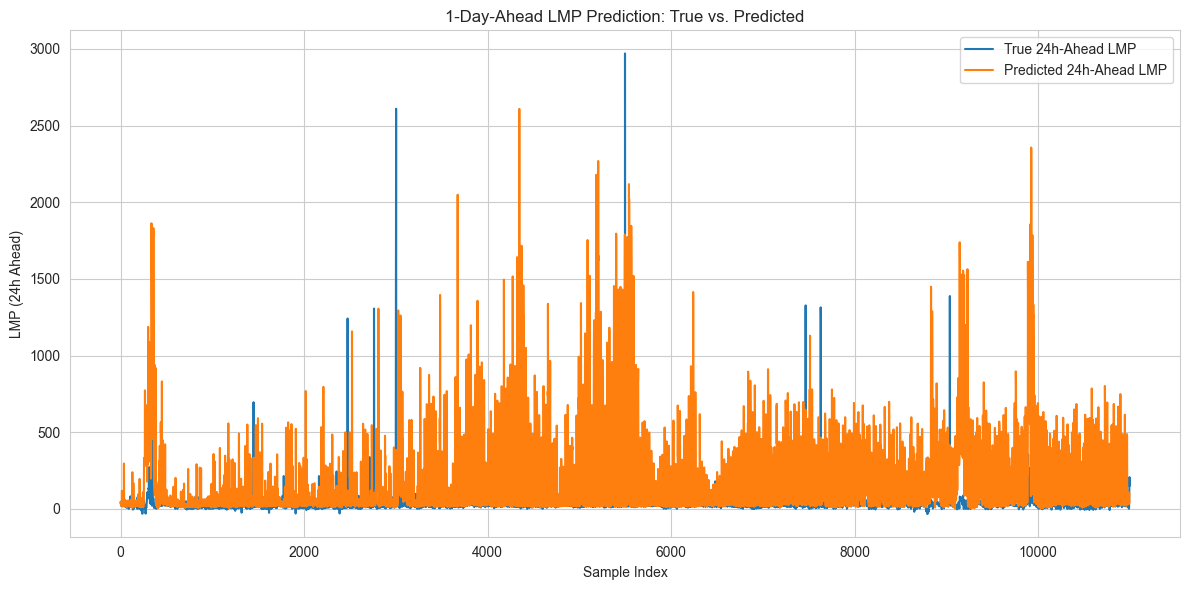

In [79]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


# 1. Drop any rows where the 24h-ahead target is NaN (the last 24 rows)
train_df = train_df.dropna(subset=['target_24h']).reset_index(drop=True)
test_df  = test_df .dropna(subset=['target_24h']).reset_index(drop=True)

# 2. Define which columns to exclude from features
exclude_cols = [
    'interval_start_local',  # timestamp
    'date',                  # date column (if present)
    'lmp_HB_BUSAVG',         # current-hour price
    'target_1w',             # 1-week ahead (if you created it)
    'target_24h'             # the 1-day ahead target itself
]

# 3. Build feature matrix and target vector
features = [c for c in train_df.columns if c not in exclude_cols]
X_train, y_train = train_df[features], train_df['target_24h']
X_test,  y_test  = test_df[features],  test_df['target_24h']

# 4. Train XGBoost regressor
model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# 5. Make 1-day-ahead predictions
y_pred = model.predict(X_test)

# 6. Compute evaluation metrics
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")

# 7. Plot true vs. predicted 1-day-ahead values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True 24h-Ahead LMP')
plt.plot(y_pred,         label='Predicted 24h-Ahead LMP')
plt.xlabel('Sample Index')
plt.ylabel('LMP (24h Ahead)')
plt.title('1-Day-Ahead LMP Prediction: True vs. Predicted')
plt.legend()
plt.tight_layout()
plt.show()


### 5.1.2 Xgboost Feature Importance

                             feature    importance
37                  lmp_roll_mean_48  10995.763364
22                     Wet Bulb Temp  10938.687137
30                           dow_cos   8923.051826
27                          hour_sin   4943.784463
6                   coal_and_lignite   4550.342157
5                         Total Load   4155.318104
2                         South Load   3473.750004
16                     Far West Temp   3342.270963
17                        North Temp   2557.322894
20                     Southern Temp   2516.218943
12                       natural_gas   2175.047526
7                              hydro   2135.734546
23  Henry Hub Natural Gas Spot Price   2112.411874
34                        lmp_lag_24   1933.364276
35                        lmp_lag_48   1862.080116
15                         East Temp   1765.742893
1                         North Load   1653.552292
3                          West Load   1496.287556
21                         West

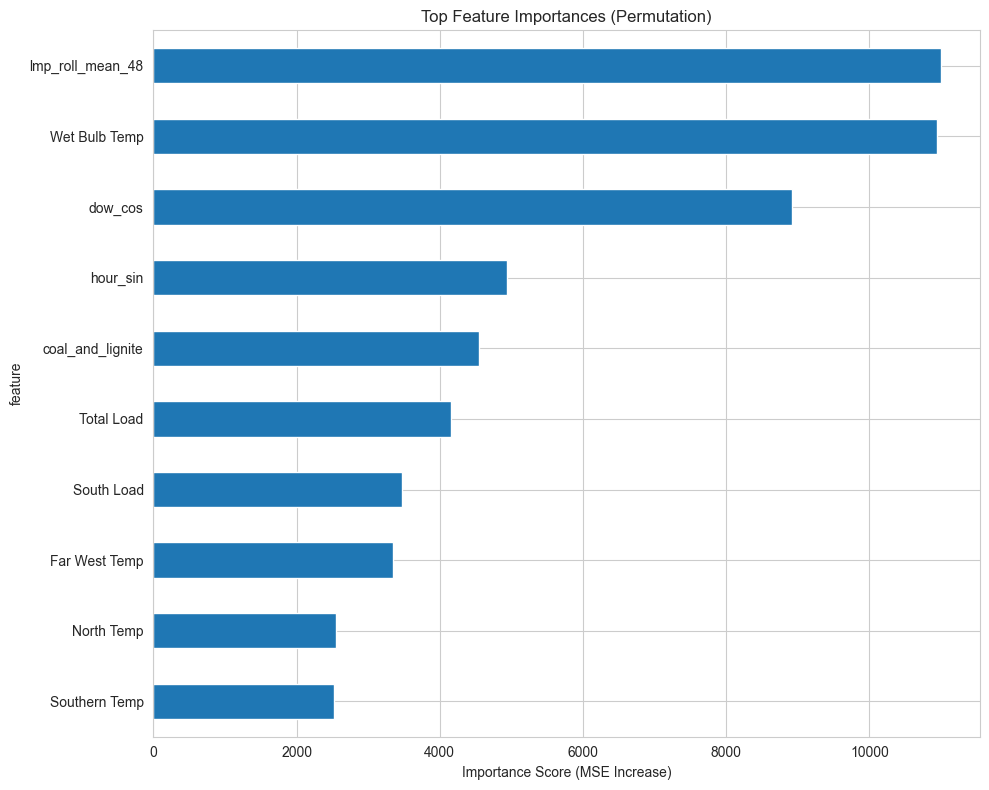

In [70]:
# Baseline performance
y_pred_baseline = model.predict(X_train)
baseline_score = mean_squared_error(y_train, y_pred_baseline)

importances = []

for col in X_train.columns:
    X_shuffled = X_train.copy()
    # Shuffle one feature
    X_shuffled[col] = np.random.permutation(X_shuffled[col].values)

    # Predict with shuffled data
    y_pred_shuffled = model.predict(X_shuffled)

    # Calculate performance
    shuffled_score = mean_squared_error(y_train, y_pred_shuffled)

    # Importance = how much worse the model got
    importance = shuffled_score - baseline_score
    importances.append(importance)

# Put into dataframe
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

# Plot top 10
top_n = 10
importance_df.head(top_n).plot(kind='barh', x='feature', y='importance', figsize=(10, 8), legend=False)
plt.title("Top Feature Importances (Permutation)")
plt.gca().invert_yaxis()
plt.xlabel("Importance Score (MSE Increase)")
plt.tight_layout()
plt.show()

### 5.1.3 Hyperparameter tuning

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import optuna

# turn off Optuna's INFO logs (including the "Best is trial..." summary)
optuna.logging.set_verbosity(logging.WARNING)

#
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

#
def objective(trial):

    params = {
        #Do not need as deep or complex trees for day-ahead predictions compared to hourly because data has smoother trends and long term temporal dependencies
        "n_estimators": trial.suggest_int("n_estimators", 100, 600), # Smaller upper limit compared to hourly
        "max_depth": trial.suggest_int("max_depth", 3, 8), # Shallower trees compared to hourly
        "learning_rate":   trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample":       trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree":trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma":           trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha":       trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda":      trial.suggest_float("reg_lambda", 0.0, 5.0),
        "verbosity":       0,
        "random_state":    42,
        "objective":       "reg:squarederror",
        "eval_metric":     "rmse"
    }

    fold_rmse = []
    for train_idx, val_idx in tscv.split(X_train):
        #
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        preds = model.predict(X_val)
        fold_rmse.append(np.sqrt(mean_squared_error(y_val, preds)))

    return float(np.mean(fold_rmse))

#
study = optuna.create_study(
    direction="minimize",
    study_name="xgb_lmp_tuning_tsCV"
)
study.optimize(objective, n_trials=50, timeout=600)

#
print("Best CV RMSE: {:.4f}".format(study.best_value))
print("Best Params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

Best CV RMSE: 225.9750
Best Params:
  n_estimators: 435
  max_depth: 8
  learning_rate: 0.0014809595408004721
  subsample: 0.6187101432319282
  colsample_bytree: 0.7939212620357949
  gamma: 2.49337384659512
  reg_alpha: 3.6779094958822887
  reg_lambda: 0.9492810763456753


### 5.1.4 Final training

In [72]:
best_params = study.best_params
final_model = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42,
    verbosity=0
)
final_model.fit(X_train, y_train, verbose=False)

#
y_pred = final_model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print(f"Final Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Final Test RMSE: 88.0737, MAE: 37.0108


### 5.1.5 Plotting Results

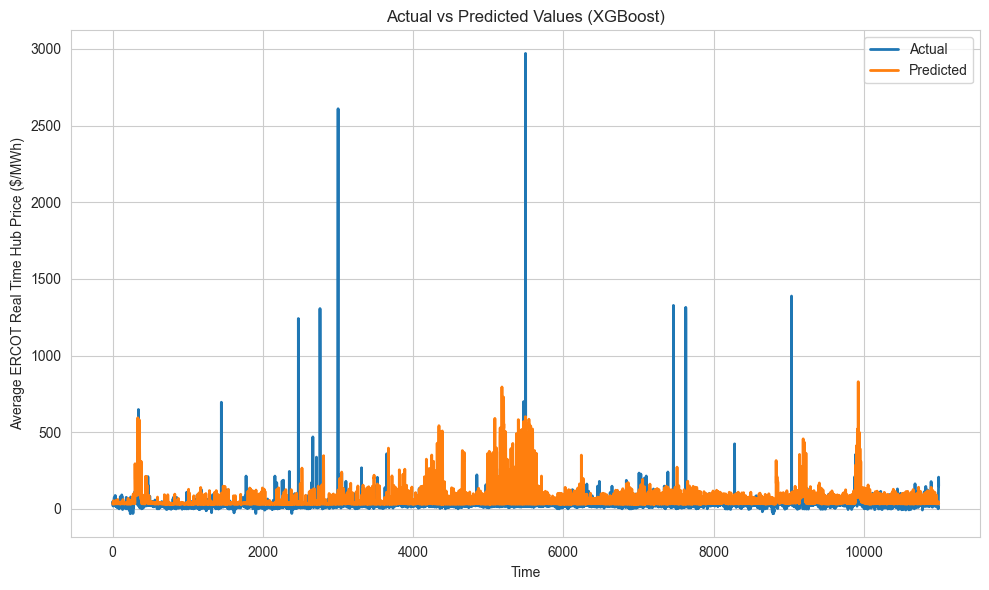

In [73]:
# Plot Actual vs Predicted over samples
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Values (XGBoost)')
plt.xlabel('Time')
plt.ylabel('Average ERCOT Real Time Hub Price ($/MWh)')
plt.legend()
plt.tight_layout()
plt.show()

## 5.2 lightgbm

### 5.2.1 baseline model

Test MSE:  27671.1625
Test RMSE: 166.3465
Test MAE:  64.2191


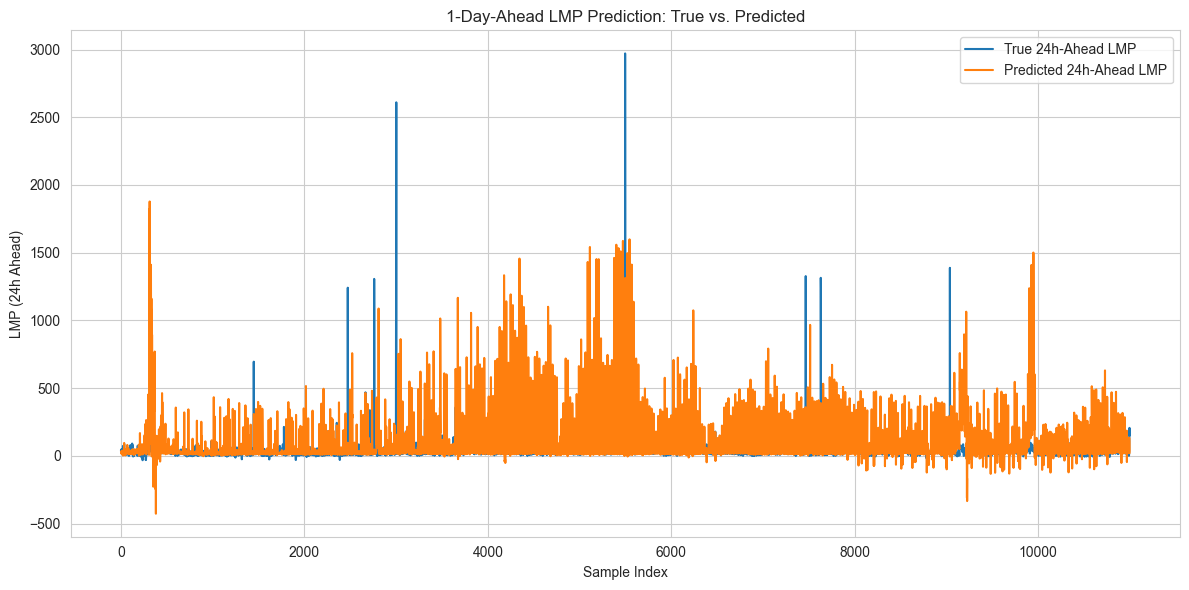

In [80]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

train_df = train_df.dropna(subset=['target_24h']).reset_index(drop=True)
test_df  = test_df .dropna(subset=['target_24h']).reset_index(drop=True)


exclude_cols = [
    'interval_start_local',  #
    'date',                  #
    'lmp_HB_BUSAVG',         #
    'target_1w',             #
    'target_24h'             #
]


features = [c for c in train_df.columns if c not in exclude_cols]
X_train, y_train = train_df[features], train_df['target_24h']
X_test,  y_test  = test_df[features],  test_df['target_24h']


model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse'
)


y_pred = model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True 24h-Ahead LMP')
plt.plot(y_pred,         label='Predicted 24h-Ahead LMP')
plt.xlabel('Sample Index')
plt.ylabel('LMP (24h Ahead)')
plt.title('1-Day-Ahead LMP Prediction: True vs. Predicted')
plt.legend()
plt.tight_layout()
plt.show()


### 5.2.2 lightgbm Feature Importance

                             feature   importance
37                  lmp_roll_mean_48  7273.629486
22                     Wet Bulb Temp  5597.617500
27                          hour_sin  2992.827123
7                              hydro  2756.041310
16                     Far West Temp  2287.680490
17                        North Temp  2194.715519
35                        lmp_lag_48  1961.854508
34                        lmp_lag_24  1942.812501
15                         East Temp  1285.535635
36                  lmp_roll_mean_24  1268.057173
19                South Central Temp  1135.825829
39                 lmp_roll_mean_168  1106.267876
12                       natural_gas  1032.490679
23  Henry Hub Natural Gas Spot Price   991.707820
14                        Coast Temp   971.053996
20                     Southern Temp   927.735048
30                           dow_cos   922.308485
21                         West Temp   892.985747
31                         lmp_lag_1   871.224532


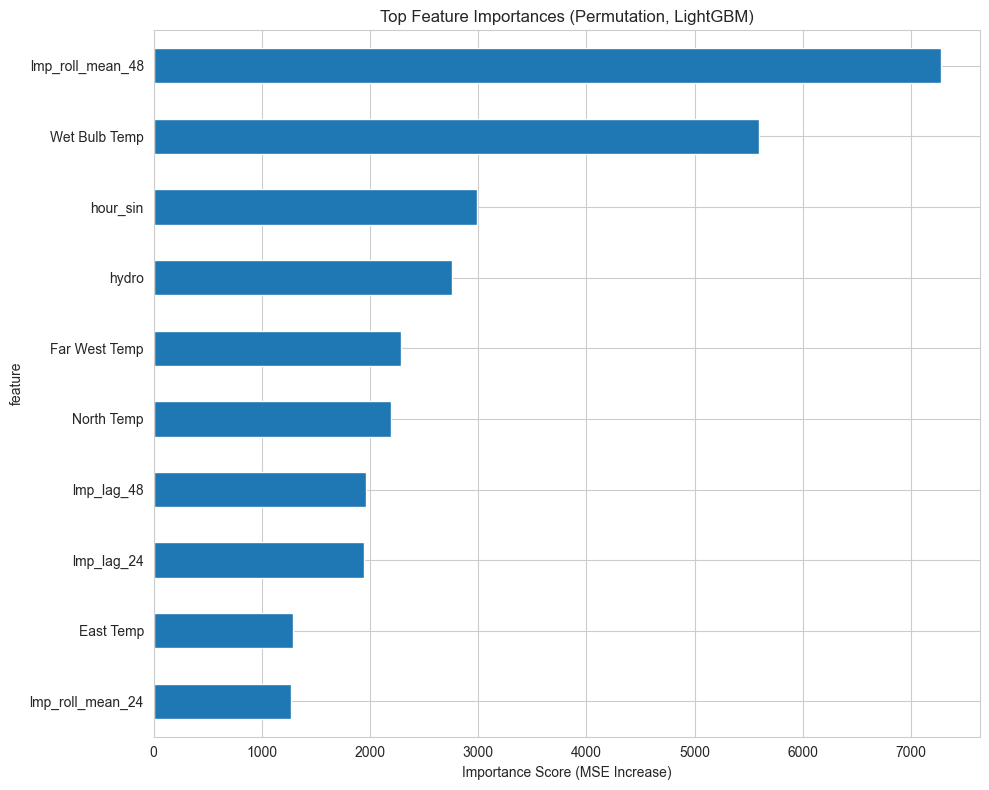

In [81]:
# Baseline model performance
y_pred_baseline = model.predict(X_train)
baseline_score = mean_squared_error(y_train, y_pred_baseline)

importances = []

# Calculate permutation importance
for col in X_train.columns:
    X_shuffled = X_train.copy()
    X_shuffled[col] = np.random.permutation(X_shuffled[col].values)

    y_pred_shuffled = model.predict(X_shuffled)
    shuffled_score = mean_squared_error(y_train, y_pred_shuffled)

    # Importance = how much worse the model got when this feature was shuffled
    importance = shuffled_score - baseline_score
    importances.append(importance)

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

# Plot top 10 features
top_n = 10
importance_df.head(top_n).plot(kind='barh', x='feature', y='importance', figsize=(10, 8), legend=False)
plt.title("Top Feature Importances (Permutation, LightGBM)")
plt.gca().invert_yaxis()
plt.xlabel("Importance Score (MSE Increase)")
plt.tight_layout()
plt.show()


### 5.2.3 Hyperparameter tuning

In [82]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

#
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

#
def objective(trial):
    params = {
        "objective":          "regression",
        "metric":             "rmse",
        "num_leaves":         trial.suggest_int("num_leaves", 20, 150),
        "max_depth":          trial.suggest_int("max_depth", 3, 10), #slightly lower max_depth with long horizons benefitting from generalization
        "learning_rate":      trial.suggest_float("learning_rate", 5e-4, 1e-3, log=True), #forecasting further ahead increases uncertainty, so slower learning rate might help
        "min_child_samples":  trial.suggest_int("min_child_samples", 10, 200),
        "min_split_gain":     trial.suggest_float("min_split_gain", 0.0, 5.0),
        "subsample":          trial.suggest_float("subsample", 0.5, 1.0),
        "subsample_freq":     trial.suggest_int("subsample_freq", 1, 10),
        "colsample_bytree":   trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha":          trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda":         trial.suggest_float("reg_lambda", 0.0, 5.0),
        #
        "verbosity":          -1,
        "random_state":       42
    }

    fold_rmse = []
    for train_idx, val_idx in tscv.split(X_train):
        #
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        gbm = lgb.LGBMRegressor(**params, n_estimators=1000)
        gbm.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            #
            callbacks=[lgb.log_evaluation(0)]
        )

        preds = gbm.predict(X_val)
        fold_rmse.append(np.sqrt(mean_squared_error(y_val, preds)))

    return float(np.mean(fold_rmse))


#
study = optuna.create_study(direction="minimize", study_name="lgb_lmp_tuning_tsCV")
study.optimize(objective, n_trials=50, timeout=600)

#
print("Best CV RMSE: {:.4f}".format(study.best_value))
print("Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")




Best CV RMSE: 225.4702
Best params:
  num_leaves: 86
  max_depth: 7
  learning_rate: 0.000956873897907092
  min_child_samples: 48
  min_split_gain: 3.3767005372387664
  subsample: 0.7046563395004269
  subsample_freq: 10
  colsample_bytree: 0.8985515997632696
  reg_alpha: 0.4402144881868746
  reg_lambda: 3.7393511951592306


### 5.2.4 Final training

In [83]:
best_params = study.best_params
final_model = lgb.LGBMRegressor(
    **best_params,
    objective="regression",
    metric="rmse",
    n_estimators=1000,
    verbosity=-1,
    random_state=42
)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.log_evaluation(0)]
)

y_pred = final_model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
print(f"Final Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Final Test RMSE: 68.6483, MAE: 27.3028


### 5.2.5 Plotting Results

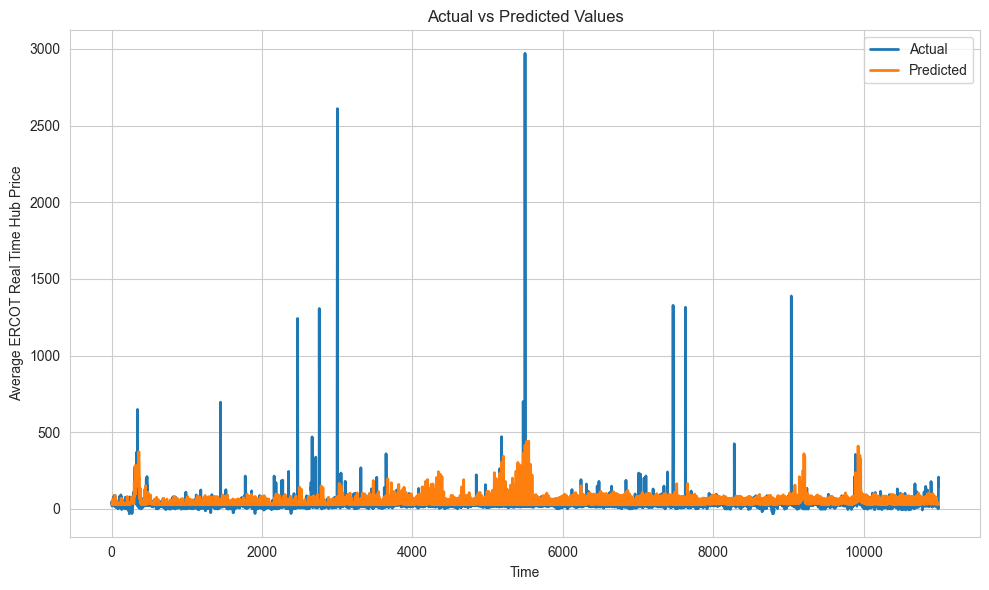

In [84]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Average ERCOT Real Time Hub Price')
plt.legend()
plt.tight_layout()
plt.show()

## 5.3 LSTM

### 5.3.1 baseline model

In [85]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


train_df = train_df.dropna(subset=['target_24h']).reset_index(drop=True)
test_df  = test_df .dropna(subset=['target_24h']).reset_index(drop=True)

exclude_cols = [
    'interval_start_local',  #
    'date',                  #
    'lmp_HB_BUSAVG',         #
    'target_24h',            #
    'target_1w'              #
]

feature_cols = [c for c in train_df.columns if c not in exclude_cols]


scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_all = scaler_x.fit_transform(train_df[feature_cols])
y_train_all = scaler_y.fit_transform(train_df[['target_24h']])

X_test_all  = scaler_x.transform(test_df[feature_cols])
y_test_all  = scaler_y.transform(test_df[['target_24h']])

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24):
        self.X, self.y, self.seq_len = X, y, seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]
        y_seq = self.y[idx+self.seq_len]  #
        return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq)

seq_len = 24
train_ds = TimeSeriesDataset(X_train_all, y_train_all, seq_len)
test_ds  = TimeSeriesDataset(X_test_all,  y_test_all,  seq_len)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)


class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, seq_len, n_features]
        out, _ = self.lstm(x)         # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]           #
        return self.fc(out)           # [batch, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = LSTMRegressor(n_features=len(feature_cols)).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


n_epochs = 20
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        y_pred = model(xb).squeeze(1)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs}, Train MSE={avg_loss:.6f}")

#
model.eval()
ys, preds = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1,1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1,1))

mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")


C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([13, 1])) that is different to the input size (torch.Size([13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Train MSE=0.000637
Epoch 2/20, Train MSE=0.000615
Epoch 3/20, Train MSE=0.000608
Epoch 4/20, Train MSE=0.000608
Epoch 5/20, Train MSE=0.000603
Epoch 6/20, Train MSE=0.000604
Epoch 7/20, Train MSE=0.000603
Epoch 8/20, Train MSE=0.000602
Epoch 9/20, Train MSE=0.000601
Epoch 10/20, Train MSE=0.000600
Epoch 11/20, Train MSE=0.000601
Epoch 12/20, Train MSE=0.000600
Epoch 13/20, Train MSE=0.000600
Epoch 14/20, Train MSE=0.000600
Epoch 15/20, Train MSE=0.000600
Epoch 16/20, Train MSE=0.000600
Epoch 17/20, Train MSE=0.000600
Epoch 18/20, Train MSE=0.000600
Epoch 19/20, Train MSE=0.000600
Epoch 20/20, Train MSE=0.000600
Test MSE:  4200.9229
Test RMSE: 64.8145
Test MAE:  20.5355


### 5.3.2 feature importance

In [86]:
from torch.utils.data import Subset

subset_len = int(0.2 * len(train_ds))
subset_idx = np.random.choice(np.arange(len(train_ds)), size=subset_len, replace=False)

subset_ds = Subset(train_ds, subset_idx)

subset_loader = DataLoader(subset_ds, batch_size=64, shuffle=False)
model.eval()
preds, ys = [], []
with torch.no_grad():
    for xb, yb in subset_loader:
        xb = xb.to(device)
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1, 1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1, 1))
base_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Base RMSE: {base_rmse:.4f}")

def permute_and_score(model, dataset, feature_idx, base_rmse, scaler_y, device):
    # Handle Subset or original TimeSeriesDataset
    if isinstance(dataset, torch.utils.data.Subset):
        base_ds = dataset.dataset
        indices = dataset.indices
        X = base_ds.X[indices].copy()
        y = base_ds.y[indices].copy()
    else:
        X = dataset.X.copy()
        y = dataset.y.copy()

    # Permute the selected feature column
    np.random.shuffle(X[:, feature_idx])

    perm_ds = TimeSeriesDataset(X, y, seq_len=24)
    loader = DataLoader(perm_ds, batch_size=64, shuffle=False)

    model.eval()
    preds, ys = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            y_pred = model(xb).squeeze(1).cpu().numpy()
            preds.append(y_pred)
            ys.append(yb.numpy())

    y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse - base_rmse

from joblib import Parallel, delayed

importances = Parallel(n_jobs=-1)(
    delayed(permute_and_score)(model, subset_ds, i, base_rmse, scaler_y, device)
    for i in range(len(feature_cols))
)

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'rmse_increase': importances
}).sort_values(by='rmse_increase', ascending=False)

print(importance_df)


Base RMSE: 237.0869
                             feature  rmse_increase
11                              wind     -30.270555
26                             month     -30.270584
35                        lmp_lag_48     -30.271367
6                   coal_and_lignite     -30.271415
23  Henry Hub Natural Gas Spot Price     -30.271528
13                             other     -30.271556
9                      power_storage     -30.271575
28                          hour_cos     -30.271613
33                         lmp_lag_3     -30.271632
7                              hydro     -30.271660
12                       natural_gas     -30.271698
39                 lmp_roll_mean_168     -30.271736
25                      day_of_month     -30.271773
34                        lmp_lag_24     -30.271830
31                         lmp_lag_1     -30.271887
29                           dow_sin     -30.271896
38                  lmp_roll_mean_96     -30.271934
20                     Southern Temp     -30

## 5.4 GRU

### 5.4.1 baseline model

In [87]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# 1. Ensure you have created the 24-hour target:
#    df['target_24h'] = df['lmp_HB_BUSAVG'].shift(-24)

# 2. Drop rows where target_24h is NaN
train_df = train_df.dropna(subset=['target_24h']).reset_index(drop=True)
test_df  = test_df .dropna(subset=['target_24h']).reset_index(drop=True)

# 3. Exclude non-feature columns
exclude_cols = [
    'interval_start_local',  # timestamp
    'date',                  # date column
    'lmp_HB_BUSAVG',         # current-hour price
    'target_24h',            # 1-day-ahead target
    'target_1w'              # 1-week-ahead (if present)
]

feature_cols = [c for c in train_df.columns if c not in exclude_cols]

# 4. Scale features and target
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_all = scaler_x.fit_transform(train_df[feature_cols])
y_train_all = scaler_y.fit_transform(train_df[['target_24h']])

X_test_all  = scaler_x.transform(test_df[feature_cols])
y_test_all  = scaler_y.transform(test_df[['target_24h']])

# 5. Dataset / DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24):
        self.X, self.y, self.seq_len = X, y, seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]
        y_seq = self.y[idx+self.seq_len]
        return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq)

seq_len = 24
train_ds = TimeSeriesDataset(X_train_all, y_train_all, seq_len)
test_ds  = TimeSeriesDataset(X_test_all,  y_test_all,  seq_len)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

# 6. GRU regressor
class GRURegressor(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, seq_len, n_features]
        out, _ = self.gru(x)        # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]         # last time step
        return self.fc(out)         # [batch, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRURegressor(n_features=len(feature_cols)).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 7. Training loop
n_epochs = 20
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        y_pred = model(xb).squeeze(1)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs} — Train MSE: {avg_loss:.6f}")

# 8. Evaluation
model.eval()
ys, preds = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1,1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1,1))

mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
print(f"\nTest MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")


C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([13, 1])) that is different to the input size (torch.Size([13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20 — Train MSE: 0.000762
Epoch 2/20 — Train MSE: 0.000626
Epoch 3/20 — Train MSE: 0.000618
Epoch 4/20 — Train MSE: 0.000617
Epoch 5/20 — Train MSE: 0.000613
Epoch 6/20 — Train MSE: 0.000610
Epoch 7/20 — Train MSE: 0.000610
Epoch 8/20 — Train MSE: 0.000608
Epoch 9/20 — Train MSE: 0.000604
Epoch 10/20 — Train MSE: 0.000604
Epoch 11/20 — Train MSE: 0.000603
Epoch 12/20 — Train MSE: 0.000603
Epoch 13/20 — Train MSE: 0.000602
Epoch 14/20 — Train MSE: 0.000602
Epoch 15/20 — Train MSE: 0.000600
Epoch 16/20 — Train MSE: 0.000601
Epoch 17/20 — Train MSE: 0.000600
Epoch 18/20 — Train MSE: 0.000600
Epoch 19/20 — Train MSE: 0.000600
Epoch 20/20 — Train MSE: 0.000600

Test MSE:  4305.2944
Test RMSE: 65.6147
Test MAE:  24.4264


### 5.4.2 feature importance

In [88]:
# Take a 20% random sample from training data
subset_len = int(0.2 * len(train_ds))
subset_idx = np.random.choice(np.arange(len(train_ds)), size=subset_len, replace=False)

subset_ds = Subset(train_ds, subset_idx)
subset_loader = DataLoader(subset_ds, batch_size=64, shuffle=False)

model.eval()
ys, preds = [], []
with torch.no_grad():
    for xb, yb in subset_loader:
        xb = xb.to(device)
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true_subset = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1, 1))
y_pred_subset = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1, 1))
base_rmse = np.sqrt(mean_squared_error(y_true_subset, y_pred_subset))
print(f"Base RMSE (on training subset): {base_rmse:.4f}")

def permute_and_score(model, dataset, feature_idx, base_rmse, scaler_y, device):
    # Handle Subset and extract .X and .y
    if isinstance(dataset, Subset):
        base_ds = dataset.dataset
        indices = dataset.indices
        X = base_ds.X[indices].copy()
        y = base_ds.y[indices].copy()
    else:
        X = dataset.X.copy()
        y = dataset.y.copy()

    # Permute selected feature across time series
    np.random.shuffle(X[:, feature_idx])

    perm_ds = TimeSeriesDataset(X, y, seq_len=24)
    loader = DataLoader(perm_ds, batch_size=64, shuffle=False)

    model.eval()
    preds, ys = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            y_pred = model(xb).squeeze(1).cpu().numpy()
            preds.append(y_pred)
            ys.append(yb.numpy())

    y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse - base_rmse

importances = Parallel(n_jobs=-1)(
    delayed(permute_and_score)(model, subset_ds, i, base_rmse, scaler_y, device)
    for i in range(len(feature_cols))
)

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'rmse_increase': importances
}).sort_values(by='rmse_increase', ascending=False)

print(importance_df.head(10))

Base RMSE (on training subset): 253.4049
               feature  rmse_increase
1           North Load      -5.245158
0                 hour      -5.245654
29             dow_sin      -5.246653
8              nuclear      -5.246818
19  South Central Temp      -5.246992
25        day_of_month      -5.247889
21           West Temp      -5.247936
26               month      -5.248369
11                wind      -5.248920
3            West Load      -5.248928


# 6 week-ahead forecasting

## 6.1 Xgboost

### 6.1.1 baseline model

Test MSE:  63582.7822
Test RMSE: 252.1563
Test MAE:  101.9208


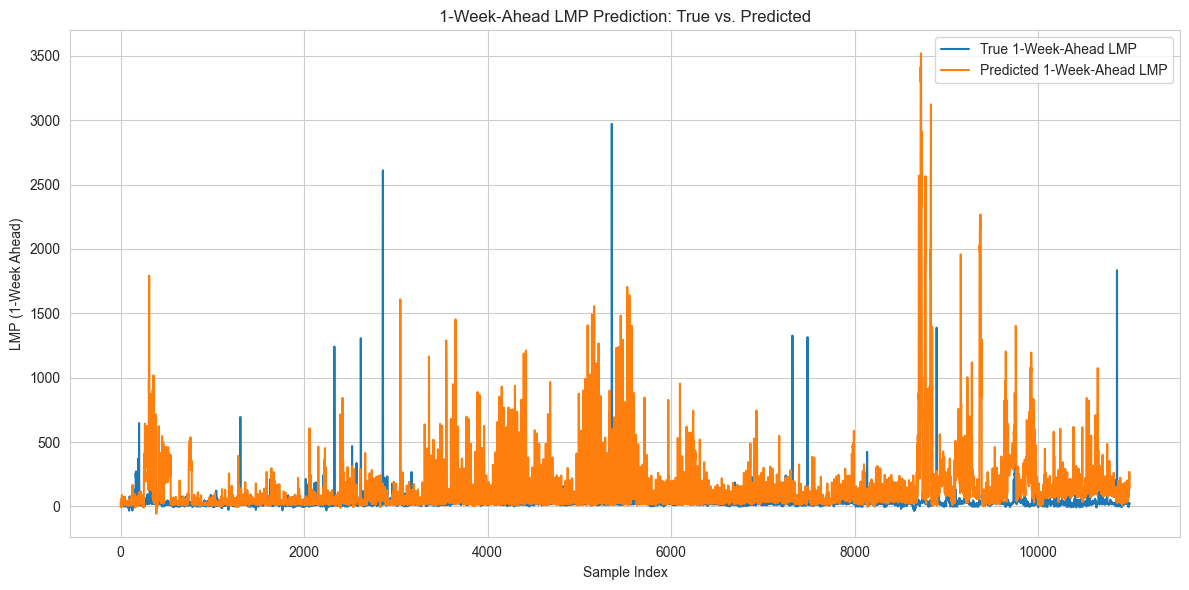

In [90]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

train_df = train_df.dropna(subset=['target_1w']).reset_index(drop=True)
test_df  = test_df .dropna(subset=['target_1w']).reset_index(drop=True)


exclude_cols = [
    'interval_start_local',  #
    'date',                  #
    'lmp_HB_BUSAVG',         #
    'target_24h',            #
    'target_1w'              #
]


features = [c for c in train_df.columns if c not in exclude_cols]
X_train, y_train = train_df[features], train_df['target_1w']
X_test,  y_test  = test_df[features],  test_df['target_1w']


model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)


y_pred = model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True 1-Week-Ahead LMP')
plt.plot(y_pred,         label='Predicted 1-Week-Ahead LMP')
plt.xlabel('Sample Index')
plt.ylabel('LMP (1-Week Ahead)')
plt.title('1-Week-Ahead LMP Prediction: True vs. Predicted')
plt.legend()
plt.tight_layout()
plt.show()


### 6.1.2 feature importance

                             feature    importance
22                     Wet Bulb Temp  69553.636133
1                         North Load  18038.975122
20                     Southern Temp  14613.625883
23  Henry Hub Natural Gas Spot Price  14502.114579
26                             month  11908.234531
37                  lmp_roll_mean_48  11683.731820
2                         South Load  11645.612090
19                South Central Temp   8055.729904
8                            nuclear   6930.055988
36                  lmp_roll_mean_24   6787.059788
16                     Far West Temp   6420.089084
15                         East Temp   6397.738960
17                        North Temp   6063.343774
14                        Coast Temp   5342.452342
12                       natural_gas   4586.888100
4                       Houston Load   3309.283999
38                  lmp_roll_mean_96   3195.114090
18                North Central Temp   2442.040975
5                         Total

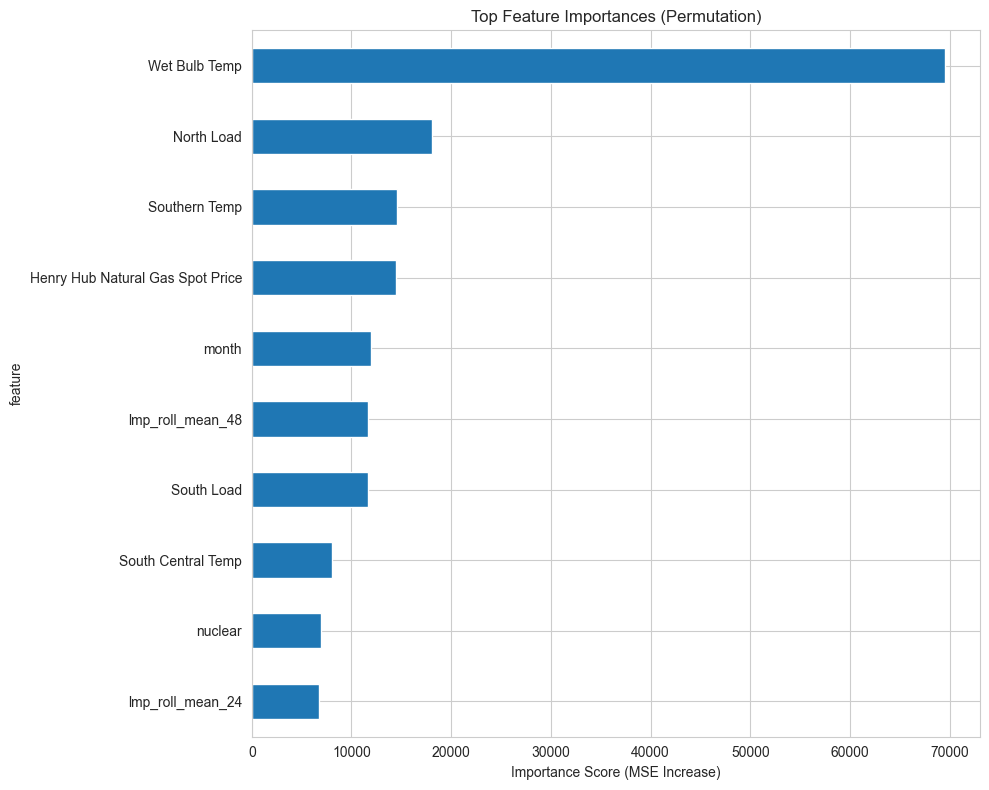

In [91]:
# Baseline performance
y_pred_baseline = model.predict(X_train)
baseline_score = mean_squared_error(y_train, y_pred_baseline)

importances = []

for col in X_train.columns:
    X_shuffled = X_train.copy()
    # Shuffle one feature
    X_shuffled[col] = np.random.permutation(X_shuffled[col].values)

    # Predict with shuffled data
    y_pred_shuffled = model.predict(X_shuffled)

    # Calculate performance
    shuffled_score = mean_squared_error(y_train, y_pred_shuffled)

    # Importance = how much worse the model got
    importance = shuffled_score - baseline_score
    importances.append(importance)

# Put into dataframe
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

# Plot top 10
top_n = 10
importance_df.head(top_n).plot(kind='barh', x='feature', y='importance', figsize=(10, 8), legend=False)
plt.title("Top Feature Importances (Permutation)")
plt.gca().invert_yaxis()
plt.xlabel("Importance Score (MSE Increase)")
plt.tight_layout()
plt.show()

### 6.1.3 hyperparameter tuning

In [92]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import optuna

# turn off Optuna's INFO logs (including the "Best is trial..." summary)
optuna.logging.set_verbosity(logging.WARNING)

#
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

#
def objective(trial):

    params = {
        #Do not need as deep or complex trees for day-ahead predictions compared to hourly because data has smoother trends and long term temporal dependencies
        "n_estimators": trial.suggest_int("n_estimators", 100, 600), # Smaller upper limit compared to hourly
        "max_depth": trial.suggest_int("max_depth", 3, 8), # Shallower trees compared to hourly
        "learning_rate":   trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample":       trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree":trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma":           trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha":       trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda":      trial.suggest_float("reg_lambda", 0.0, 5.0),
        "verbosity":       0,
        "random_state":    42,
        "objective":       "reg:squarederror",
        "eval_metric":     "rmse"
    }

    fold_rmse = []
    for train_idx, val_idx in tscv.split(X_train):
        #
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        preds = model.predict(X_val)
        fold_rmse.append(np.sqrt(mean_squared_error(y_val, preds)))

    return float(np.mean(fold_rmse))

#
study = optuna.create_study(
    direction="minimize",
    study_name="xgb_lmp_tuning_tsCV"
)
study.optimize(objective, n_trials=50, timeout=600)

#
print("Best CV RMSE: {:.4f}".format(study.best_value))
print("Best Params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

Best CV RMSE: 227.9567
Best Params:
  n_estimators: 508
  max_depth: 7
  learning_rate: 0.002449362704418437
  subsample: 0.5278213631174887
  colsample_bytree: 0.546272938076862
  gamma: 2.126851164974473
  reg_alpha: 4.181758051255969
  reg_lambda: 4.996604367024414


### 6.1.4 final training

In [93]:
best_params = study.best_params
final_model = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42,
    verbosity=0
)
final_model.fit(X_train, y_train, verbose=False)

#
y_pred = final_model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print(f"Final Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Final Test RMSE: 101.6082, MAE: 38.3186


### 6.1.5 plotting results

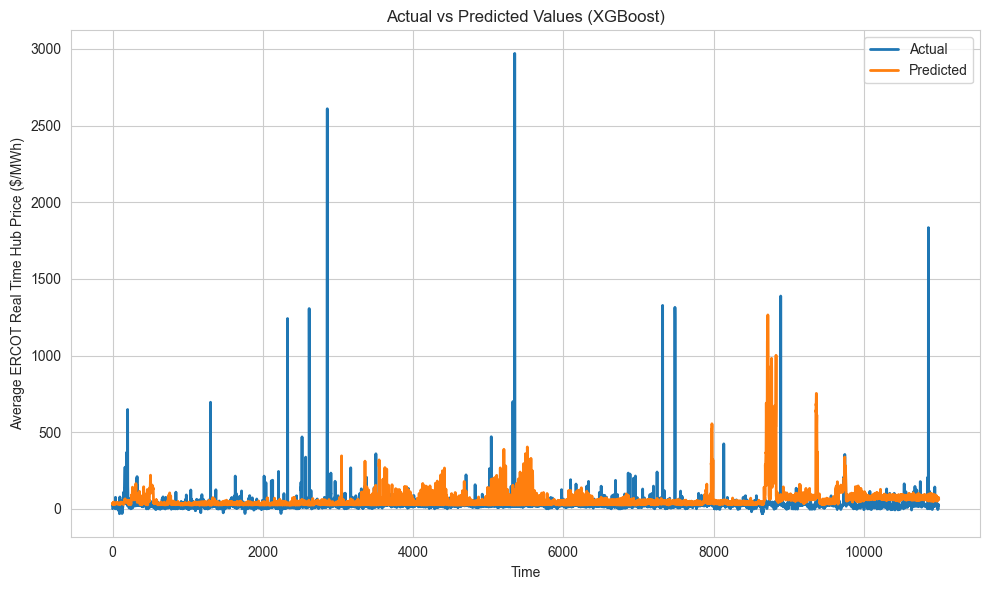

In [94]:
# Plot Actual vs Predicted over samples
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Values (XGBoost)')
plt.xlabel('Time')
plt.ylabel('Average ERCOT Real Time Hub Price ($/MWh)')
plt.legend()
plt.tight_layout()
plt.show()

## 6.2 LightGBM

### 6.2.1 baseline model

Test MSE:  174225.3094
Test RMSE: 417.4031
Test MAE:  142.6070


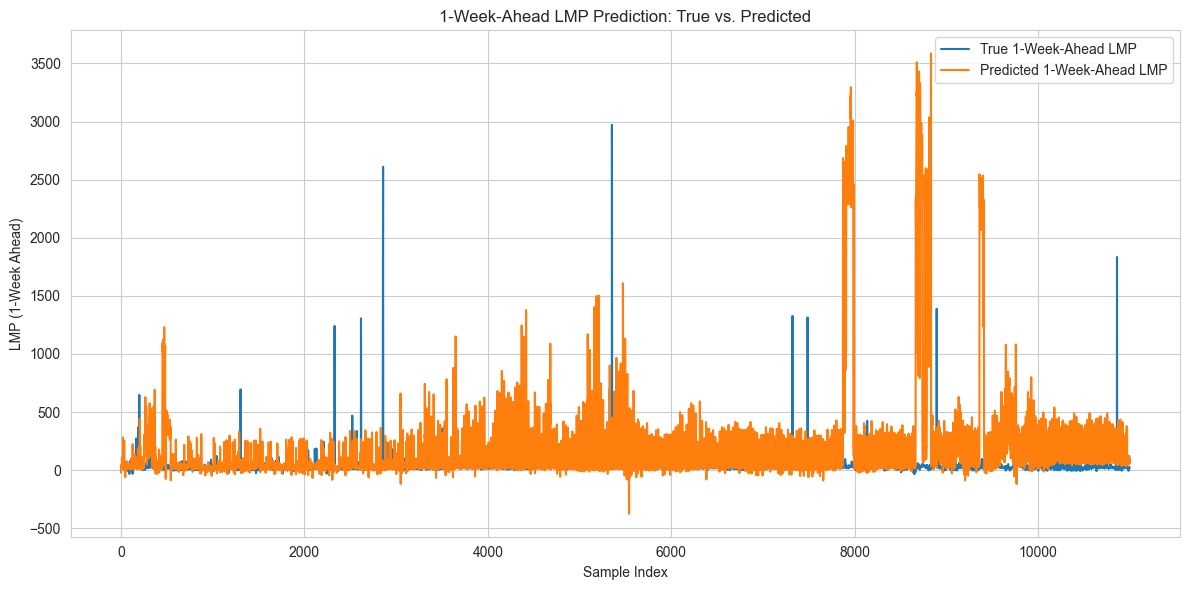

In [96]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

train_df = train_df.dropna(subset=['target_1w']).reset_index(drop=True)
test_df  = test_df .dropna(subset=['target_1w']).reset_index(drop=True)


exclude_cols = [
    'interval_start_local',
    'date',
    'lmp_HB_BUSAVG',
    'target_24h',   #
    'target_1w'     #
]


features = [c for c in train_df.columns if c not in exclude_cols]
X_train, y_train = train_df[features], train_df['target_1w']
X_test,  y_test  = test_df[features],  test_df['target_1w']


model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse'
)


y_pred = model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")

#
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True 1-Week-Ahead LMP')
plt.plot(y_pred,         label='Predicted 1-Week-Ahead LMP')
plt.xlabel('Sample Index')
plt.ylabel('LMP (1-Week Ahead)')
plt.title('1-Week-Ahead LMP Prediction: True vs. Predicted')
plt.legend()
plt.tight_layout()
plt.show()


### 6.2.2 feature importance

                             feature    importance
22                     Wet Bulb Temp  34279.410041
23  Henry Hub Natural Gas Spot Price  22733.265409
8                            nuclear  11205.622723
37                  lmp_roll_mean_48  10450.970142
26                             month   9252.695224
2                         South Load   7674.601407
1                         North Load   7542.524844
14                        Coast Temp   7434.068663
36                  lmp_roll_mean_24   6414.531338
17                        North Temp   5463.333532
16                     Far West Temp   3559.686964
25                      day_of_month   3213.639846
15                         East Temp   3013.128112
12                       natural_gas   2047.614864
39                 lmp_roll_mean_168   1813.395725
38                  lmp_roll_mean_96   1601.515481
6                   coal_and_lignite   1581.101730
20                     Southern Temp   1565.524707
18                North Central

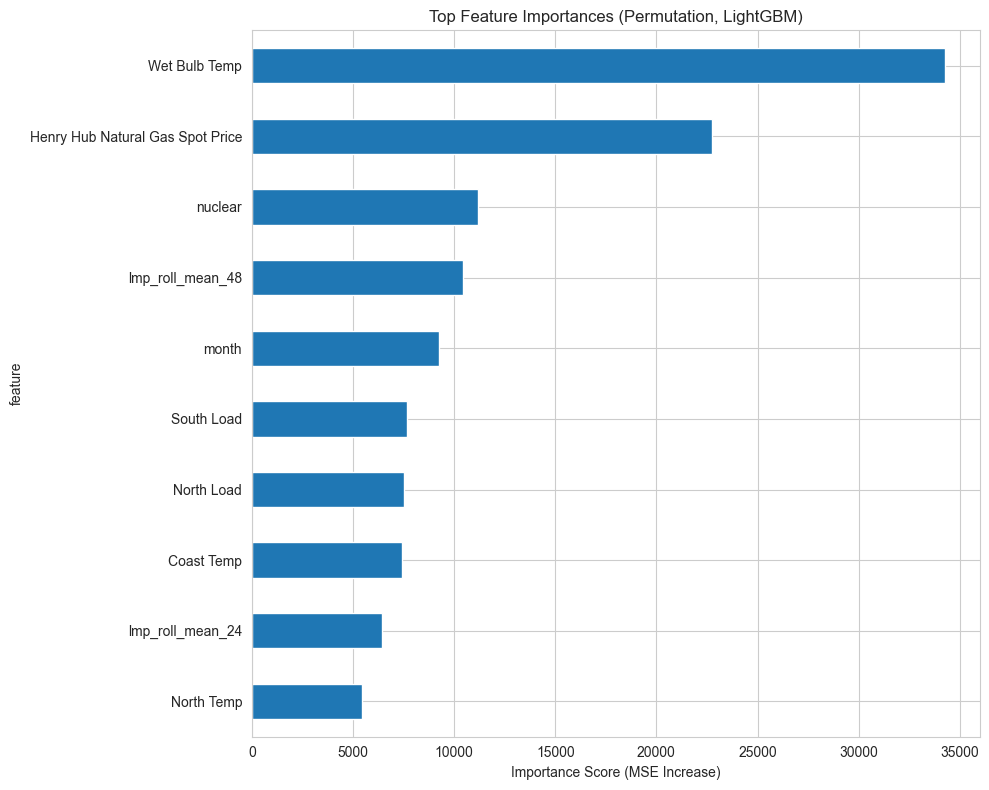

In [97]:
# Baseline model performance
y_pred_baseline = model.predict(X_train)
baseline_score = mean_squared_error(y_train, y_pred_baseline)

importances = []

# Calculate permutation importance
for col in X_train.columns:
    X_shuffled = X_train.copy()
    X_shuffled[col] = np.random.permutation(X_shuffled[col].values)

    y_pred_shuffled = model.predict(X_shuffled)
    shuffled_score = mean_squared_error(y_train, y_pred_shuffled)

    # Importance = how much worse the model got when this feature was shuffled
    importance = shuffled_score - baseline_score
    importances.append(importance)

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

# Plot top 10 features
top_n = 10
importance_df.head(top_n).plot(kind='barh', x='feature', y='importance', figsize=(10, 8), legend=False)
plt.title("Top Feature Importances (Permutation, LightGBM)")
plt.gca().invert_yaxis()
plt.xlabel("Importance Score (MSE Increase)")
plt.tight_layout()
plt.show()


### 6.2.3 hyperparameter tuning

In [98]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

#
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

#
def objective(trial):
    params = {
        "objective":          "regression",
        "metric":             "rmse",
        "num_leaves":         trial.suggest_int("num_leaves", 20, 150),
        "max_depth":          trial.suggest_int("max_depth", 3, 10), #slightly lower max_depth with long horizons benefitting from generalization
        "learning_rate":      trial.suggest_float("learning_rate", 5e-4, 1e-3, log=True), #forecasting further ahead increases uncertainty, so slower learning rate might help
        "min_child_samples":  trial.suggest_int("min_child_samples", 10, 200),
        "min_split_gain":     trial.suggest_float("min_split_gain", 0.0, 5.0),
        "subsample":          trial.suggest_float("subsample", 0.5, 1.0),
        "subsample_freq":     trial.suggest_int("subsample_freq", 1, 10),
        "colsample_bytree":   trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha":          trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda":         trial.suggest_float("reg_lambda", 0.0, 5.0),
        #
        "verbosity":          -1,
        "random_state":       42
    }

    fold_rmse = []
    for train_idx, val_idx in tscv.split(X_train):
        #
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        gbm = lgb.LGBMRegressor(**params, n_estimators=1000)
        gbm.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            #
            callbacks=[lgb.log_evaluation(0)]
        )

        preds = gbm.predict(X_val)
        fold_rmse.append(np.sqrt(mean_squared_error(y_val, preds)))

    return float(np.mean(fold_rmse))


#
study = optuna.create_study(direction="minimize", study_name="lgb_lmp_tuning_tsCV")
study.optimize(objective, n_trials=50, timeout=600)

#
print("Best CV RMSE: {:.4f}".format(study.best_value))
print("Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")




Best CV RMSE: 228.0636
Best params:
  num_leaves: 148
  max_depth: 9
  learning_rate: 0.000997658556155288
  min_child_samples: 177
  min_split_gain: 0.6477442728976937
  subsample: 0.6781081164857756
  subsample_freq: 4
  colsample_bytree: 0.5827972706083436
  reg_alpha: 4.985443470441803
  reg_lambda: 3.5441050073792213


### 6.2.4 final training

In [99]:
best_params = study.best_params
final_model = lgb.LGBMRegressor(
    **best_params,
    objective="regression",
    metric="rmse",
    n_estimators=1000,
    verbosity=-1,
    random_state=42
)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.log_evaluation(0)]
)

y_pred = final_model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
print(f"Final Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Final Test RMSE: 80.8074, MAE: 33.6983


### 6.2.5 ploting result

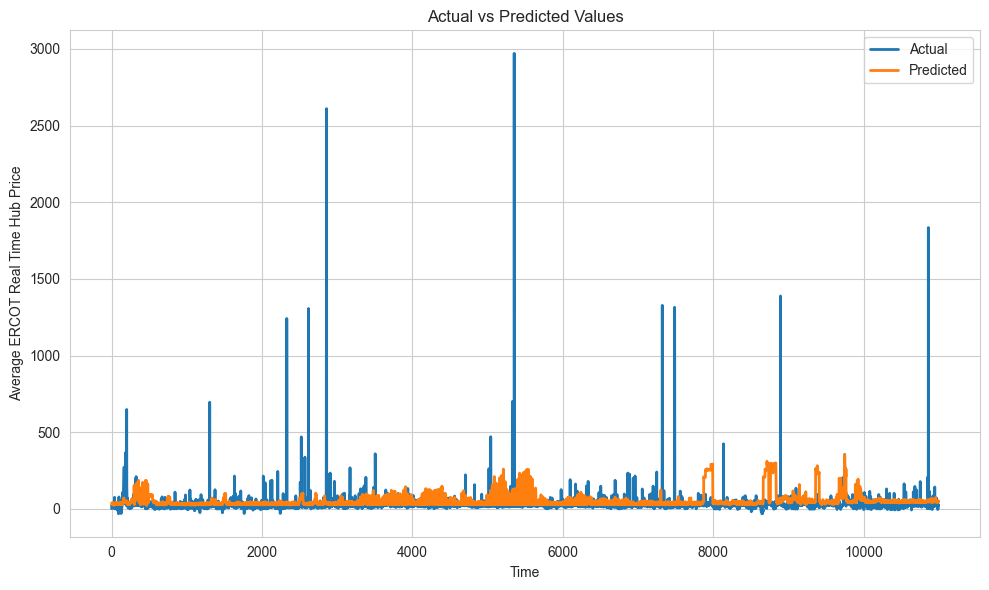

In [100]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Average ERCOT Real Time Hub Price')
plt.legend()
plt.tight_layout()
plt.show()

## 6.3 LSTM

### 6.3.1 baseline model

In [101]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

train_df = train_df.dropna(subset=['target_1w']).reset_index(drop=True)
test_df  = test_df .dropna(subset=['target_1w']).reset_index(drop=True)

exclude_cols = [
    'interval_start_local',  #
    'date',                  #
    'lmp_HB_BUSAVG',         #
    'target_24h',            #
    'target_1w'              #
]

feature_cols = [c for c in train_df.columns if c not in exclude_cols]


scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_all = scaler_x.fit_transform(train_df[feature_cols])
y_train_all = scaler_y.fit_transform(train_df[['target_1w']])

X_test_all  = scaler_x.transform(test_df[feature_cols])
y_test_all  = scaler_y.transform(test_df[['target_1w']])


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24):
        self.X, self.y, self.seq_len = X, y, seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]
        y_seq = self.y[idx+self.seq_len]
        return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq)

seq_len = 24
train_ds = TimeSeriesDataset(X_train_all, y_train_all, seq_len)
test_ds  = TimeSeriesDataset(X_test_all,  y_test_all,  seq_len)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)


class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, seq_len, n_features]
        out, _ = self.lstm(x)         # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]           #
        return self.fc(out)           # [batch, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = LSTMRegressor(n_features=len(feature_cols)).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 20
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        y_pred = model(xb).squeeze(1)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs}, Train MSE={avg_loss:.6f}")

#
model.eval()
ys, preds = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1,1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1,1))

mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")


C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([13, 1])) that is different to the input size (torch.Size([13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Train MSE=0.000649
Epoch 2/20, Train MSE=0.000617
Epoch 3/20, Train MSE=0.000609
Epoch 4/20, Train MSE=0.000607
Epoch 5/20, Train MSE=0.000606
Epoch 6/20, Train MSE=0.000605
Epoch 7/20, Train MSE=0.000603
Epoch 8/20, Train MSE=0.000604
Epoch 9/20, Train MSE=0.000603
Epoch 10/20, Train MSE=0.000602
Epoch 11/20, Train MSE=0.000602
Epoch 12/20, Train MSE=0.000602
Epoch 13/20, Train MSE=0.000601
Epoch 14/20, Train MSE=0.000601
Epoch 15/20, Train MSE=0.000600
Epoch 16/20, Train MSE=0.000600
Epoch 17/20, Train MSE=0.000600
Epoch 18/20, Train MSE=0.000600
Epoch 19/20, Train MSE=0.000600
Epoch 20/20, Train MSE=0.000600
Test MSE:  4469.8599
Test RMSE: 66.8570
Test MAE:  17.5116


### 6.3.2 feature importance

In [102]:
from torch.utils.data import Subset

subset_len = int(0.2 * len(train_ds))
subset_idx = np.random.choice(np.arange(len(train_ds)), size=subset_len, replace=False)

subset_ds = Subset(train_ds, subset_idx)

subset_loader = DataLoader(subset_ds, batch_size=64, shuffle=False)
model.eval()
preds, ys = [], []
with torch.no_grad():
    for xb, yb in subset_loader:
        xb = xb.to(device)
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1, 1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1, 1))
base_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Base RMSE: {base_rmse:.4f}")

def permute_and_score(model, dataset, feature_idx, base_rmse, scaler_y, device):
    # Handle Subset or original TimeSeriesDataset
    if isinstance(dataset, torch.utils.data.Subset):
        base_ds = dataset.dataset
        indices = dataset.indices
        X = base_ds.X[indices].copy()
        y = base_ds.y[indices].copy()
    else:
        X = dataset.X.copy()
        y = dataset.y.copy()

    # Permute the selected feature column
    np.random.shuffle(X[:, feature_idx])

    perm_ds = TimeSeriesDataset(X, y, seq_len=24)
    loader = DataLoader(perm_ds, batch_size=64, shuffle=False)

    model.eval()
    preds, ys = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            y_pred = model(xb).squeeze(1).cpu().numpy()
            preds.append(y_pred)
            ys.append(yb.numpy())

    y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse - base_rmse

from joblib import Parallel, delayed

importances = Parallel(n_jobs=-1)(
    delayed(permute_and_score)(model, subset_ds, i, base_rmse, scaler_y, device)
    for i in range(len(feature_cols))
)

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'rmse_increase': importances
}).sort_values(by='rmse_increase', ascending=False)

print(importance_df)


Base RMSE: 280.5545
                             feature  rmse_increase
27                          hour_sin     -63.796743
8                            nuclear     -63.815116
10                             solar     -63.815936
2                         South Load     -63.817757
29                           dow_sin     -63.817802
30                           dow_cos     -63.818883
4                       Houston Load     -63.819550
1                         North Load     -63.819640
14                        Coast Temp     -63.820010
18                North Central Temp     -63.820145
16                     Far West Temp     -63.820595
0                               hour     -63.820974
17                        North Temp     -63.821433
3                          West Load     -63.821487
19                South Central Temp     -63.821542
20                     Southern Temp     -63.821857
15                         East Temp     -63.822362
28                          hour_cos     -63

## 6.4 GRU

### 6.4.1 baseline model

In [103]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

train_df = train_df.dropna(subset=['target_1w']).reset_index(drop=True)
test_df  = test_df .dropna(subset=['target_1w']).reset_index(drop=True)


exclude_cols = [
    'interval_start_local',  #
    'date',                  #
    'lmp_HB_BUSAVG',         #
    'target_24h',            #
    'target_1w'              #
]
feature_cols = [c for c in train_df.columns if c not in exclude_cols]


scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_all = scaler_x.fit_transform(train_df[feature_cols])
y_train_all = scaler_y.fit_transform(train_df[['target_1w']])

X_test_all  = scaler_x.transform(test_df[feature_cols])
y_test_all  = scaler_y.transform(test_df[['target_1w']])


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24):
        self.X, self.y, self.seq_len = X, y, seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx : idx + self.seq_len]
        y_seq = self.y[idx + self.seq_len]
        return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq)

seq_len = 24
train_ds = TimeSeriesDataset(X_train_all, y_train_all, seq_len)
test_ds  = TimeSeriesDataset(X_test_all,  y_test_all,  seq_len)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)


class GRURegressor(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, seq_len, n_features]
        out, _ = self.gru(x)         # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]          #
        return self.fc(out)          # [batch, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = GRURegressor(n_features=len(feature_cols)).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


n_epochs = 20
for epoch in range(1, n_epochs + 1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        y_pred = model(xb).squeeze(1)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs}, Train MSE={avg_loss:.6f}")

#
model.eval()
ys, preds = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1, 1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1, 1))

mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")


C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([13, 1])) that is different to the input size (torch.Size([13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Train MSE=0.000699
Epoch 2/20, Train MSE=0.000637
Epoch 3/20, Train MSE=0.000635
Epoch 4/20, Train MSE=0.000619
Epoch 5/20, Train MSE=0.000616
Epoch 6/20, Train MSE=0.000620
Epoch 7/20, Train MSE=0.000610
Epoch 8/20, Train MSE=0.000613
Epoch 9/20, Train MSE=0.000608
Epoch 10/20, Train MSE=0.000605
Epoch 11/20, Train MSE=0.000603
Epoch 12/20, Train MSE=0.000603
Epoch 13/20, Train MSE=0.000600
Epoch 14/20, Train MSE=0.000600
Epoch 15/20, Train MSE=0.000601
Epoch 16/20, Train MSE=0.000601
Epoch 17/20, Train MSE=0.000600
Epoch 18/20, Train MSE=0.000600
Epoch 19/20, Train MSE=0.000601
Epoch 20/20, Train MSE=0.000600
Test MSE:  4819.2915
Test RMSE: 69.4211
Test MAE:  29.9232


### 6.4.2 feature importance

In [104]:
from torch.utils.data import Subset

subset_len = int(0.2 * len(train_ds))
subset_idx = np.random.choice(np.arange(len(train_ds)), size=subset_len, replace=False)

subset_ds = Subset(train_ds, subset_idx)

subset_loader = DataLoader(subset_ds, batch_size=64, shuffle=False)
model.eval()
preds, ys = [], []
with torch.no_grad():
    for xb, yb in subset_loader:
        xb = xb.to(device)
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1, 1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1, 1))
base_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Base RMSE: {base_rmse:.4f}")

def permute_and_score(model, dataset, feature_idx, base_rmse, scaler_y, device):
    # Handle Subset or original TimeSeriesDataset
    if isinstance(dataset, torch.utils.data.Subset):
        base_ds = dataset.dataset
        indices = dataset.indices
        X = base_ds.X[indices].copy()
        y = base_ds.y[indices].copy()
    else:
        X = dataset.X.copy()
        y = dataset.y.copy()

    # Permute the selected feature column
    np.random.shuffle(X[:, feature_idx])

    perm_ds = TimeSeriesDataset(X, y, seq_len=24)
    loader = DataLoader(perm_ds, batch_size=64, shuffle=False)

    model.eval()
    preds, ys = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            y_pred = model(xb).squeeze(1).cpu().numpy()
            preds.append(y_pred)
            ys.append(yb.numpy())

    y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1, 1))
    y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse - base_rmse

from joblib import Parallel, delayed

importances = Parallel(n_jobs=-1)(
    delayed(permute_and_score)(model, subset_ds, i, base_rmse, scaler_y, device)
    for i in range(len(feature_cols))
)

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'rmse_increase': importances
}).sort_values(by='rmse_increase', ascending=False)

print(importance_df)


Base RMSE: 213.0214
                             feature  rmse_increase
22                     Wet Bulb Temp      28.638409
29                           dow_sin      28.637068
17                        North Temp      28.637011
2                         South Load      28.636946
26                             month      28.636696
14                        Coast Temp      28.636405
18                North Central Temp      28.636405
27                          hour_sin      28.636268
3                          West Load      28.636114
10                             solar      28.636025
15                         East Temp      28.635936
35                        lmp_lag_48      28.635912
28                          hour_cos      28.635896
13                             other      28.635855
19                South Central Temp      28.635766
23  Henry Hub Natural Gas Spot Price      28.635758
9                      power_storage      28.635734
4                       Houston Load      28